# The life of an athlete with type 1 diabetes: descriptives

Descriptives for the 2019 training season of 14 TNN athletes

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
from copy import copy

from plot import *
from calc import glucose_levels, mmoll_mgdl, mgdl_mmoll, timestamp_to_seconds
from calc import stats_cgm as stat_func
from config import DATA_PATH, SAVE_PATH

In [2]:
SAVE_PATH = 'descriptives/'

for folder in ('availability', 'hist', 'cdf', 'boxplot', 'time_in_zone', 'time_cycling', 'events'):
    if not os.path.exists(SAVE_PATH+'Dexcom/'+folder):
        os.makedirs(SAVE_PATH+'Dexcom/'+folder)

section palette


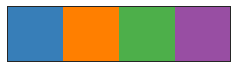

athlete palette


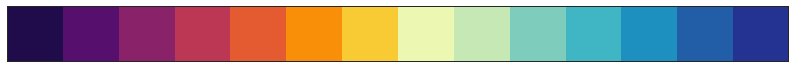

race palette


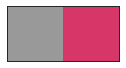

In [3]:
print("section palette")
sns.palplot(color_sec.values()) ; plt.show()

print("athlete palette")
sns.palplot(palette_ath) ; plt.show()

print("race palette")
sns.palplot(color_race.values()) ; plt.show()


In [4]:
# perform some adjustments to the glucose levels, so that floats don't fall in between glucose levels
# e.g. 69.5 falls in between 69 and 70
glucose_levels = {level: (lmin-(1-1e-8), lmax) if level.startswith('hyper') else (
    (lmin, lmax+(1-1e-8)) if level.startswith('hypo') else (
    (lmin, lmax))) for level, (lmin, lmax) in glucose_levels.items()}

## Data

### Read data

**Athlete characteristics**

In [5]:
info = pd.read_csv(DATA_PATH+'agg/info.csv')
info = info.reset_index()
info = info.rename(columns={'index':'RIDER'})
info

RIDER gender  nationality  age  diabetes_duration     weight      bf(%)  \
0       1      M  Switzerland   22                 11  60.500000   9.066667   
1       2      M        Italy   30                 14  71.633333   8.833333   
2       3      M      Ireland   26                  7  66.733333   6.566667   
3       4      M    Australia   19                  7  78.666667   9.433333   
4       5      M  Netherlands   25                  6  69.633333   7.700000   
5       6      M    Australia   20                  9  56.700000   4.950000   
6       7      M        Italy   22                  6  65.333333   8.066667   
7       8      M  New Zealand   20                 17  65.000000  11.900000   
8       9      M       France   23                 10  63.100000   8.533333   
9      10      M           UK   27                 17  75.466667   7.700000   
10     11      M  Netherlands   24                 15  70.700000   8.900000   
11     12      M        Spain   30                  8  64.000000   5.600000   
12     13      M      Hungary   34                  1  60.333333   4.866667   
13     14      M      Finland   27                 17  75.166667   9.333333   
14     15      M       France   25                 15  73.766667   7.200000   
15     16      M   Uzbekistan   22                 13  56.666667   9.466667   
16     17      M       France   22                  4        NaN        NaN   
17     18      M           US   26                  2        NaN        NaN   

    HbA1c         FTP        LTHR       HRmax     VO2max  height  
0     6.7  307.000000  176.333333  192.333333  68.888889   174.0  
1     6.6  326.000000  168.666667  181.666667  66.915285   178.0  
2     6.8  298.000000  171.000000  180.000000  66.666164   171.0  
3     7.8  356.000000  170.333333  187.333333  67.333333   178.0  
4     6.5  341.000000  179.666667  192.666667  72.857143   183.0  
5     6.4  298.500000  173.000000  184.500000  70.781588   169.0  
6     5.9  298.500000  171.500000  180.500000  72.203125   167.0  
7     7.7  292.000000  187.000000  204.000000  64.000000   165.0  
8     7.2  278.666667  182.333333  195.000000  67.522310   173.0  
9     7.3  377.333333  177.000000  194.333333  73.982571   185.0  
10    6.4  317.000000  175.000000  190.000000  65.000000   179.0  
11    6.0  347.000000  158.333333  178.666667  75.937500   178.0  
12    6.3  345.666667  173.000000  182.333333  76.666667   179.0  
13    7.1  348.000000  169.000000  189.500000  66.500000   187.0  
14    6.4  389.000000  185.000000  198.000000  66.000000   179.0  
15    6.6  283.333333  125.610000  200.333333  74.678571   170.0  
16    NaN         NaN         NaN         NaN        NaN   167.0  
17    NaN         NaN         NaN         NaN        NaN   180.0

**Professional**

In [6]:
pro = pd.read_csv(DATA_PATH+'info/pro.csv')
pro = pro.sort_values('RIDER')

Select only people for whom we have *ethics*

In [7]:
pro = pro[pro.ethics == 1]
pro = pro.drop('ethics', axis=1)

# anonymize file
pro = pro.drop('name', axis=1)
pro['RIDER'] = pro['RIDER'].astype(int)
pro = pro.reset_index(drop=True)

pro

RIDER 2014 2015 2016 2017 2018 2019 2020 2021
0       1    -    -    -  DEV  DEV  PRO  PRO  PRO
1       2  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
2       3  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
3       4    -    -    -  DEV  PRO  PRO  PRO  PRO
4       5    -  PRO  PRO  PRO  PRO  PRO  PRO  PRO
5       6    -    -    -  DEV  DEV  PRO  PRO  PRO
6       7    -    -  DEV  PRO  PRO  PRO  PRO  PRO
7       8    -    -    -  DEV  DEV  DEV  PRO  PRO
8       9    -    -    -  PRO  PRO  PRO  PRO  PRO
9      10    -    -  DEV  DEV  PRO  PRO  PRO  PRO
10     11    -  PRO  PRO  PRO    -  DEV  PRO  PRO
11     12  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
12     13    -    -    -    -    -  PRO  PRO  PRO
13     14  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
14     15  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
15     16    -    -    -  DEV  DEV  PRO  PRO  DEV
16     17    -    -    -    -    -    -    -    -
17     18    -    -    -  DEV  DEV  DEV  DEV  PRO

**Season dates**

In [8]:
season = pd.read_csv(DATA_PATH+'calendar/season_dates.csv', index_col=[0,1], header=[0,1])
season = season.reset_index().drop('level_1', axis=1)
season = season.rename(columns={'level_0':'RIDER'})
season

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


RIDER        2015                    2016                    2017  \
               start         end       start         end       start   
0      1         NaN         NaN         NaN         NaN  2016-12-06   
1      2  2014-11-17  2015-10-18  2015-11-24  2016-10-28  2016-11-15   
2      3  2014-11-06  2015-10-18  2015-11-06  2016-10-23  2016-12-06   
3      4         NaN         NaN         NaN         NaN  2016-11-15   
4      5  2014-11-14  2015-11-08  2015-11-27  2016-10-30  2016-11-12   
5      6         NaN         NaN         NaN         NaN  2016-12-12   
6      7         NaN         NaN  2015-10-07  2016-04-16  2016-11-07   
7      8         NaN         NaN         NaN         NaN  2016-12-14   
8      9         NaN         NaN         NaN         NaN  2016-12-06   
9     10         NaN         NaN  2015-11-06  2016-10-17  2016-11-04   
10    11  2014-11-02  2015-11-12  2015-12-01  2016-11-12  2016-12-07   
11    12  2014-11-15  2015-10-29  2015-11-24  2016-10-22  2016-11-07   
12    13         NaN         NaN         NaN         NaN         NaN   
13    14  2014-11-14  2015-10-25  2015-12-02  2016-10-30  2016-11-13   
14    15  2014-11-17  2015-10-18  2015-11-12  2016-10-23  2016-11-14   
15    16         NaN         NaN         NaN         NaN  2016-12-14   
16    17         NaN         NaN         NaN         NaN         NaN   
17    18         NaN         NaN         NaN         NaN  2016-12-13   

                      2018                    2019                    2020  \
           end       start         end       start         end       start   
0   2017-11-05  2017-11-13  2018-10-20  2018-11-05  2019-10-20  2019-11-04   
1   2017-09-11  2017-10-23  2018-10-02  2018-10-23  2019-10-16  2019-11-04   
2   2017-10-05  2017-11-13  2018-10-31  2018-11-19  2019-10-20  2019-11-13   
3   2017-09-30  2017-10-05  2018-11-01  2018-11-12  2019-10-16  2019-11-04   
4   2017-09-23  2017-10-03  2018-10-17  2018-11-12  2019-10-20  2019-11-11   
5   2017-10-14  2017-10-30  2018-10-25  2018-12-01  2019-10-01  2019-10-21   
6   2017-11-05  2017-11-28  2018-10-17  2018-11-29  2019-10-27  2019-12-02   
7   2017-11-05  2017-11-19  2018-12-12  2018-12-24  2019-10-16  2019-10-24   
8   2017-11-05  2017-11-20  2018-09-24  2018-11-05  2019-09-23  2019-10-14   
9   2017-11-12  2017-11-27  2018-11-10  2018-11-22  2019-10-28  2019-11-11   
10  2017-10-22         NaN         NaN  2018-10-15  2019-06-23  2019-10-23   
11  2017-10-31  2017-11-06  2018-11-11  2018-11-26  2019-11-05  2019-11-18   
12         NaN         NaN         NaN  2018-12-12  2019-10-20  2019-11-18   
13  2017-11-20  2017-12-21  2018-11-01  2018-11-12  2019-09-09  2019-10-21   
14  2017-11-01  2017-11-27  2018-10-21  2018-11-12  2019-10-20  2019-11-09   
15  2017-09-10  2017-11-21  2018-11-02  2018-11-19  2019-09-29  2019-11-14   
16         NaN         NaN         NaN         NaN         NaN         NaN   
17  2017-10-22  2017-11-20  2018-08-12  2018-10-22  2019-10-13  2019-11-09   

                      2021              
           end       start         end  
0   2020-09-23  2020-10-08  2021-10-30  
1   2020-10-11  2020-11-09  2021-10-04  
2   2020-10-16  2020-11-16  2021-10-03  
3   2020-10-28  2020-11-16  2021-08-14  
4   2020-10-31  2020-11-16  2021-08-31  
5   2020-07-17  2020-11-01  2021-09-03  
6   2020-10-12  2020-11-09  2021-09-30  
7   2020-09-27  2020-11-01  2021-10-03  
8   2020-10-12  2020-11-05  2021-10-01  
9   2020-10-11  2020-11-16  2021-10-17  
10  2020-10-02  2020-11-01  2021-09-17  
11  2020-10-08  2020-11-01  2021-09-03  
12  2020-10-11  2020-11-16  2021-09-05  
13  2020-10-12  2020-11-02  2021-09-20  
14  2020-10-15  2020-11-07  2021-10-29  
15  2020-10-31  2020-11-23  2021-09-30  
16         NaN         NaN         NaN  
17  2020-10-18  2020-11-11  2021-10-05

**TrainingPeaks (aggregated)**

In [9]:
tp_agg = pd.read_csv(DATA_PATH+'agg/trainingpeaks_day.csv', index_col=[0,1], header=[0,1])
tp_agg = tp_agg.reset_index()
tp_agg['date'] = pd.to_datetime(tp_agg['date'])
tp_agg

RIDER       date            TIME                       \
                       timestamp_count  local_timestamp_min   
0         1 2016-11-22          7446.0  2016-11-22 12:58:57   
1         1 2016-11-23          7312.0  2016-11-23 14:29:13   
2         1 2016-11-24          6285.0  2016-11-24 09:53:38   
3         1 2016-11-26          7445.0  2016-11-26 10:00:35   
4         1 2016-12-06         11222.0  2016-12-06 09:11:34   
...     ...        ...             ...                  ...   
30207    18 2021-11-18          4767.0  2021-11-18 14:58:17   
30208    18 2021-11-25         10912.0  2021-11-25 09:50:57   
30209    18 2021-11-26          8737.0  2021-11-26 10:12:34   
30210    18 2021-11-27         18222.0  2021-11-27 09:31:58   
30211    18 2021-11-28         14549.0  2021-11-28 10:02:22   

                           CALENDAR                                   \
       local_timestamp_max     race travel race_3d_mean race_7d_mean   
0      2016-11-22 15:15:40    False   True          0.0          0.0   
1      2016-11-23 16:35:14    False  False          0.0          0.0   
2      2016-11-24 16:56:38    False  False          0.0          0.0   
3      2016-11-26 12:12:52    False  False          0.0          0.0   
4      2016-12-06 16:11:38    False  False          0.0          0.0   
...                    ...      ...    ...          ...          ...   
30207  2021-11-18 16:19:15    False  False          0.0          0.0   
30208  2021-11-25 12:54:14    False  False          0.0          0.0   
30209  2021-11-26 12:39:08    False  False          0.0          0.0   
30210  2021-11-27 14:36:43    False  False          0.0          0.0   
30211  2021-11-28 14:21:57    False  False          0.0          0.0   

                     ...             LOC                                  \
      travel_3d_any  ... distance_up_std distance_up_min distance_up_max   
0              True  ...    17801.944942            3.02        60211.87   
1              True  ...    19148.044265            0.00        66126.45   
2              True  ...     9053.264194            3.43        34317.18   
3             False  ...    18440.805479            1.10        65340.95   
4             False  ...    19543.224138            0.00        64799.24   
...             ...  ...             ...             ...             ...   
30207         False  ...     9128.714210            0.00        29709.74   
30208         False  ...    21912.188008            0.00        80574.10   
30209         False  ...    19439.456819            0.00        62597.98   
30210         False  ...    38862.374584            0.00       130010.95   
30211         False  ...    33132.807679            3.57       109086.89   

                                                                            \
      distance_up_sum distance_up_energy distance_up_peaks distance_up_rms   
0        1.615842e+08       6.454802e+12               0.0    29442.856294   
1        2.109715e+08       9.441041e+12               0.0    35932.864834   
2        6.765391e+07       1.379010e+12               0.0    14812.591736   
3        1.908990e+08       8.218843e+12               0.0    33225.612828   
4        2.761122e+08       1.133536e+13               1.0    31782.096599   
...               ...                ...               ...             ...   
30207    5.001524e+07       1.099600e+12               0.0    15187.800246   
30208    2.989028e+08       1.488329e+13               0.0    36931.529437   
30209    1.875908e+08       8.146286e+12               0.0    30535.051494   
30210    7.310406e+08       6.144018e+13               0.0    58066.844495   
30211    5.640191e+08       4.316849e+13               0.0    54471.190338   

                                                           
      distance_up_iqr acceleration_iqr elevation_gain_iqr  
0                 NaN              NaN                NaN  
1                 NaN              NaN                NaN  
2    

**Dexcom (aggregated)**

In [12]:
dc_agg = pd.read_csv(DATA_PATH+'agg/dexcom_day.csv')
dc_agg['date'] = pd.to_datetime(dc_agg['date'])
dc_agg

/local/home/evanweenen/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (73,74) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


RIDER       date  time_in_hypo_exercise  time_in_hypoL2_exercise  \
0          1 2013-12-31                    NaN                      NaN   
1          1 2014-01-01                    NaN                      NaN   
2          1 2014-01-02                    NaN                      NaN   
3          1 2014-01-03                    NaN                      NaN   
4          1 2014-01-04                    NaN                      NaN   
...      ...        ...                    ...                      ...   
52610     18 2021-12-28                    NaN                      NaN   
52611     18 2021-12-29                    NaN                      NaN   
52612     18 2021-12-30                    NaN                      NaN   
52613     18 2021-12-31                    NaN                      NaN   
52614     18 2022-01-01                    NaN                      NaN   

       time_in_hypoL1_exercise  time_in_target_exercise  \
0                          NaN                      NaN   
1                          NaN                      NaN   
2                          NaN                      NaN   
3                          NaN                      NaN   
4                          NaN                      NaN   
...                        ...                      ...   
52610                      NaN                      NaN   
52611                      NaN                      NaN   
52612                      NaN                      NaN   
52613                      NaN                      NaN   
52614                      NaN                      NaN   

       time_in_hyper_exercise  time_in_hyperL1_exercise  \
0                         NaN                       NaN   
1                         NaN                       NaN   
2                         NaN                       NaN   
3                         NaN                       NaN   
4                         NaN                       NaN   
...                       ...                       ...   
52610                     NaN                       NaN   
52611                     NaN                       NaN   
52612                     NaN                       NaN   
52613                     NaN                       NaN   
52614                     NaN                       NaN   

       time_in_hyperL2_exercise  glucose_mean_exercise  ...  glucose_std_14d  \
0                           NaN                    NaN  ...              NaN   
1                           NaN                    NaN  ...              NaN   
2                           NaN                    NaN  ...              NaN   
3                           NaN                    NaN  ...              NaN   
4                           NaN                    NaN  ...              NaN   
...                         ...                    ...  ...              ...   
52610                       NaN                    NaN  ...              NaN   
52611                       NaN                    NaN  ...              NaN   
52612                       NaN                    NaN  ...              NaN   
52613                       NaN                    NaN  ...              NaN   
52614                       NaN                    NaN  ...              NaN   

       glucose_cv_14d  glucose_rate_14d  completeness_14d  count_14d  \
0                 NaN               NaN               0.0          0   
1                 NaN               NaN               0.0          0   
2                 NaN               NaN               0.0          0   
3                 NaN               NaN               0.0          0   
4                 NaN               NaN               0.0          0   
...               ...               ...               ...        ...   
52610             NaN               NaN               0.0          0   
52611             NaN               NaN               0.0          0   
52612             NaN               NaN               0.0          0   
52613  

**Dexcom (full)**

In [13]:
dc = pd.read_csv(DATA_PATH+'Dexcom/clean/dexcom_clean5.csv')

dc['timestamp'] = pd.to_datetime(dc['timestamp'])
dc['local_timestamp'] = pd.to_datetime(dc['local_timestamp'])

dc['date'] = pd.to_datetime(dc.local_timestamp.dt.date)
dc

RIDER           timestamp  Glucose Value (mg/dL)  \
0             1 2014-01-01 00:00:00                    NaN   
1             1 2014-01-01 00:05:00                    NaN   
2             1 2014-01-01 00:10:00                    NaN   
3             1 2014-01-01 00:15:00                    NaN   
4             1 2014-01-01 00:20:00                    NaN   
...         ...                 ...                    ...   
15147643     18 2021-12-31 23:35:00                    NaN   
15147644     18 2021-12-31 23:40:00                    NaN   
15147645     18 2021-12-31 23:45:00                    NaN   
15147646     18 2021-12-31 23:50:00                    NaN   
15147647     18 2021-12-31 23:55:00                    NaN   

             local_timestamp  exercise  recovery   wake  sleep   race  travel  \
0        2013-12-31 20:00:00     False     False   True  False  False   False   
1        2013-12-31 20:05:00     False     False   True  False  False   False   
2        2013-12-31 20:10:00     False     False   True  False  False   False   
3        2013-12-31 20:15:00     False     False   True  False  False   False   
4        2013-12-31 20:20:00     False     False   True  False  False   False   
...                      ...       ...       ...    ...    ...    ...     ...   
15147643 2022-01-01 00:35:00     False     False  False   True  False   False   
15147644 2022-01-01 00:40:00     False     False  False   True  False   False   
15147645 2022-01-01 00:45:00     False     False  False   True  False   False   
15147646 2022-01-01 00:50:00     False     False  False   True  False   False   
15147647 2022-01-01 00:55:00     False     False  False   True  False   False   

               date  
0        2013-12-31  
1        2013-12-31  
2        2013-12-31  
3        2013-12-31  
4        2013-12-31  
...             ...  
15147643 2022-01-01  
15147644 2022-01-01  
15147645 2022-01-01  
15147646 2022-01-01  
15147647 2022-01-01  

[15147648 rows x 11 columns]

### Plot data availability

In [14]:
dc_avail = dc_agg.pivot(index='RIDER', columns='date', values='completeness_1d')

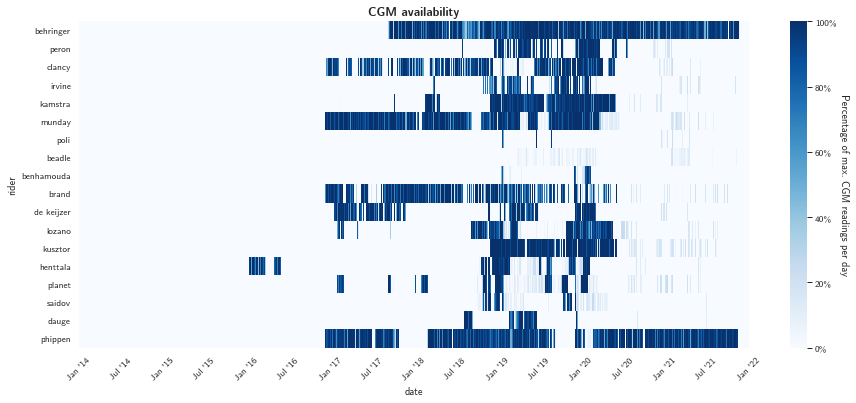

In [15]:
ax = plot_availability(dc_avail, rot_months=45, itv_months=6)
plt.title('CGM availability', fontweight='bold', fontsize=12)
savefig('availability/glucose_availability_all', yticks=ax)

In [16]:
pro_list = pro.set_index('RIDER').stack().replace({'-':'np.nan'}).reset_index().rename(columns={'level_1':'year', 0:'pro'})
pro_list['year'] = pro_list['year'].astype(int)
pro_list.columns = pd.MultiIndex.from_product([pro_list.columns, ['']])
pro_list

RIDER  year     pro
                       
0       1  2014  np.nan
1       1  2015  np.nan
2       1  2016  np.nan
3       1  2017     DEV
4       1  2018     DEV
..    ...   ...     ...
139    18  2017     DEV
140    18  2018     DEV
141    18  2019     DEV
142    18  2020     DEV
143    18  2021     PRO

[144 rows x 3 columns]

In [17]:
# note that this is not an accurate list of pro's but is just used for demonstration
# (does not take into account start and end of the season)
tp_agg['year'] = tp_agg['date'].dt.year
tp_agg = pd.merge(tp_agg, pro_list, on=['RIDER', 'year'], how='left')
tp_agg = tp_agg.drop([('year')], axis=1)
tp_agg

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


RIDER       date            TIME                       \
                       timestamp_count  local_timestamp_min   
0         1 2016-11-22          7446.0  2016-11-22 12:58:57   
1         1 2016-11-23          7312.0  2016-11-23 14:29:13   
2         1 2016-11-24          6285.0  2016-11-24 09:53:38   
3         1 2016-11-26          7445.0  2016-11-26 10:00:35   
4         1 2016-12-06         11222.0  2016-12-06 09:11:34   
...     ...        ...             ...                  ...   
30207    18 2021-11-18          4767.0  2021-11-18 14:58:17   
30208    18 2021-11-25         10912.0  2021-11-25 09:50:57   
30209    18 2021-11-26          8737.0  2021-11-26 10:12:34   
30210    18 2021-11-27         18222.0  2021-11-27 09:31:58   
30211    18 2021-11-28         14549.0  2021-11-28 10:02:22   

                           CALENDAR                                   \
       local_timestamp_max     race travel race_3d_mean race_7d_mean   
0      2016-11-22 15:15:40    False   True          0.0          0.0   
1      2016-11-23 16:35:14    False  False          0.0          0.0   
2      2016-11-24 16:56:38    False  False          0.0          0.0   
3      2016-11-26 12:12:52    False  False          0.0          0.0   
4      2016-12-06 16:11:38    False  False          0.0          0.0   
...                    ...      ...    ...          ...          ...   
30207  2021-11-18 16:19:15    False  False          0.0          0.0   
30208  2021-11-25 12:54:14    False  False          0.0          0.0   
30209  2021-11-26 12:39:08    False  False          0.0          0.0   
30210  2021-11-27 14:36:43    False  False          0.0          0.0   
30211  2021-11-28 14:21:57    False  False          0.0          0.0   

                     ...             LOC                                  \
      travel_3d_any  ... distance_up_min distance_up_max distance_up_sum   
0              True  ...            3.02        60211.87    1.615842e+08   
1              True  ...            0.00        66126.45    2.109715e+08   
2              True  ...            3.43        34317.18    6.765391e+07   
3             False  ...            1.10        65340.95    1.908990e+08   
4             False  ...            0.00        64799.24    2.761122e+08   
...             ...  ...             ...             ...             ...   
30207         False  ...            0.00        29709.74    5.001524e+07   
30208         False  ...            0.00        80574.10    2.989028e+08   
30209         False  ...            0.00        62597.98    1.875908e+08   
30210         False  ...            0.00       130010.95    7.310406e+08   
30211         False  ...            3.57       109086.89    5.640191e+08   

                                                                            \
      distance_up_energy distance_up_peaks distance_up_rms distance_up_iqr   
0           6.454802e+12               0.0    29442.856294             NaN   
1           9.441041e+12               0.0    35932.864834             NaN   
2           1.379010e+12               0.0    14812.591736             NaN   
3           8.218843e+12               0.0    33225.612828             NaN   
4           1.133536e+13               1.0    31782.096599             NaN   
...                  ...               ...             ...             ...   
30207       1.099600e+12               0.0    15187.800246             NaN   
30208       1.488329e+13               0.0    36931.529437             NaN   
30209       8.146286e+12               0.0    30535.051494             NaN   
30210       6.144018e+13               0.0    58066.844495             NaN   
30211       4.316849e+13               0.0    54471.190338             NaN   

                                              pro  
      acceleration_iqr elevation_gain_iqr          
0                  NaN                NaN  np.nan  
1                  NaN                NaN  np.nan  
2                  NaN               

In [15]:
tp_avail = tp_agg.pivot(index='RIDER', columns='date', values='pro')
tp_avail = tp_avail.replace({'PRO':2, 'DEV':1, 'np.nan':np.nan})

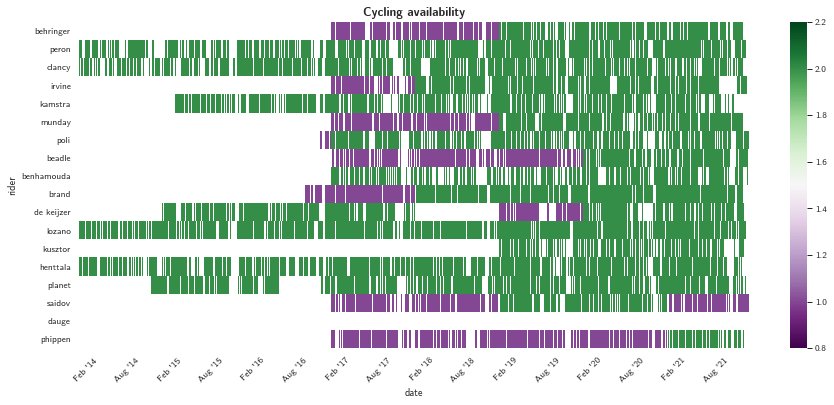

In [16]:
ax = plot_availability(tp_avail, cmap='PRGn', vmin=0.8, vmax=2.2, 
                       rot_months=45, itv_months=6, plot_colorbar=False)
plt.title('Cycling availability', fontweight='bold', fontsize=12)
savefig('availability/glucose_availability_all', dtype='TrainingPeaks', yticks=ax)

In [17]:
tp_agg = tp_agg.drop('pro', axis=1)

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [18]:
dc_agg = dc_agg.dropna(subset=['glucose_mean_1d'])

In [19]:
print("Data available: ")
print("TrainingPeaks: N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom: N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))

Data available: 
TrainingPeaks: N = 18 ; D = 30212
Dexcom: N = 18 ; D = 11786


### Select data

Select riders that were pro in 2019

In [20]:
ATHLETES = pro.loc[pro['2019'] == 'PRO', 'RIDER'].to_list()

In [21]:
info = info[info.RIDER.isin(ATHLETES)].set_index('RIDER')
season = season[season.RIDER.isin(ATHLETES)].set_index('RIDER')

In [22]:
print("Data available: ")
print("TrainingPeaks: N =", len(tp_agg[tp_agg.RIDER.isin(ATHLETES)].RIDER.unique()), 
      "; D =", len(tp_agg[tp_agg.RIDER.isin(ATHLETES)]))
print("Dexcom: N =", len(dc_agg[dc_agg.RIDER.isin(ATHLETES)].RIDER.unique()), 
      "; D =", len(dc_agg[dc_agg.RIDER.isin(ATHLETES)]))

Data available: 
TrainingPeaks: N = 14 ; D = 25116
Dexcom: N = 14 ; D = 9229


Select beginning and end of the training season in 2019

In [23]:
season = season['2019']

season['start'] = pd.to_datetime(season['start'])
season['end'] = pd.to_datetime(season['end'])

season_list = season.apply(lambda x: pd.date_range(x[0], x[1], freq='1D'), axis=1)\
    .apply(pd.Series).stack().reset_index().drop('level_1', axis=1).rename(columns={0:'date'})
season_list

RIDER       date
0         1 2018-11-05
1         1 2018-11-06
2         1 2018-11-07
3         1 2018-11-08
4         1 2018-11-09
...     ...        ...
4642     16 2019-09-25
4643     16 2019-09-26
4644     16 2019-09-27
4645     16 2019-09-28
4646     16 2019-09-29

[4647 rows x 2 columns]

In [24]:
tp_agg = pd.merge(tp_agg, season_list, how='inner', on=['RIDER', 'date'])
tp_agg

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


RIDER       date            TIME                       \
                      timestamp_count  local_timestamp_min   
0        1 2018-11-05          7767.0  2018-11-05 09:34:13   
1        1 2018-11-06          8065.0  2018-11-06 09:24:16   
2        1 2018-11-07         11349.0  2018-11-07 10:05:29   
3        1 2018-11-08          7649.0  2018-11-08 09:52:38   
4        1 2018-11-09         11297.0  2018-11-09 11:14:27   
...    ...        ...             ...                  ...   
3823    16 2019-09-22          7113.0  2019-09-22 10:00:18   
3824    16 2019-09-24          6530.0  2019-09-24 15:39:16   
3825    16 2019-09-27          7462.0  2019-09-27 14:50:03   
3826    16 2019-09-28          3157.0  2019-09-28 07:48:34   
3827    16 2019-09-29          3188.0  2019-09-29 08:00:16   

                          CALENDAR                                   \
      local_timestamp_max     race travel race_3d_mean race_7d_mean   
0     2018-11-05 11:44:12    False  False          0.0         0.00   
1     2018-11-06 11:51:24    False  False          0.0         0.00   
2     2018-11-07 14:45:37    False  False          0.0         0.00   
3     2018-11-08 12:00:51    False  False          0.0         0.00   
4     2018-11-09 14:30:32    False  False          0.0         0.00   
...                   ...      ...    ...          ...          ...   
3823  2019-09-22 11:58:50     True  False          1.0         1.00   
3824  2019-09-24 17:33:43    False   True          0.5         0.75   
3825  2019-09-27 16:56:26    False  False          0.0         0.50   
3826  2019-09-28 11:16:50    False  False          0.0         0.25   
3827  2019-09-29 10:33:36    False  False          0.0         0.00   

                    ...             LOC                                  \
     travel_3d_any  ... distance_up_std distance_up_min distance_up_max   
0            False  ...    18656.226401            3.59        65349.97   
1            False  ...    19199.276476            2.92        66307.17   
2            False  ...    19563.878883            1.51        62788.58   
3            False  ...    15849.203522            5.32        58178.67   
4            False  ...    26199.242609            2.23        88539.50   
...            ...  ...             ...             ...             ...   
3823         False  ...    26055.541836            0.00        89795.72   
3824          True  ...    14619.302426            0.00        49505.13   
3825         False  ...    17700.026352            0.00        58930.55   
3826         False  ...     3065.843556            0.00        11575.00   
3827         False  ...     5300.419197            0.00        17869.29   

                                                                           \
     distance_up_sum distance_up_energy distance_up_peaks distance_up_rms   
0       1.944342e+08       8.506042e+12               0.0    33093.073022   
1       2.071938e+08       9.171050e+12               0.0    33721.534886   
2       2.167544e+08       8.801185e+12               0.0    27847.856015   
3       1.592105e+08       5.851699e+12               0.0    27659.139890   
4       3.576181e+08       2.085233e+13               0.0    42963.110579   
...              ...                ...               ...             ...   
3823    2.669970e+08       1.614758e+13               0.0    47646.102977   
3824    1.409365e+08       4.623329e+12               0.0    26608.525456   
3825    1.924826e+08       7.640674e+12              14.0    31999.133272   
3826    1.519483e+07       1.040321e+11               2.0     5740.457015   
3827    2.324267e+07       2.624825e+11               1.0     9073.837953   

                                                          
     distance_up_iqr acceleration_iqr elevation_gain_iqr  
0                NaN              NaN                NaN  
1                NaN              NaN                NaN  
2                NaN              NaN                NaN  
3

In [25]:
dc_agg = pd.merge(dc_agg, season_list, how='inner', on=['RIDER', 'date'])
dc_agg

RIDER       date  time_in_hypo_exercise  time_in_hypoL2_exercise  \
0         1 2018-11-05                   10.0                      4.0   
1         1 2018-11-06                    1.0                      0.0   
2         1 2018-11-07                   27.0                     10.0   
3         1 2018-11-08                   10.0                      1.0   
4         1 2018-11-09                    3.0                      0.0   
...     ...        ...                    ...                      ...   
3055     16 2019-04-25                    2.0                      0.0   
3056     16 2019-04-26                    0.0                      0.0   
3057     16 2019-04-27                    0.0                      0.0   
3058     16 2019-04-30                    0.0                      0.0   
3059     16 2019-08-12                    0.0                      0.0   

      time_in_hypoL1_exercise  time_in_target_exercise  \
0                         6.0                      2.0   
1                         1.0                     19.0   
2                        17.0                     25.0   
3                         9.0                     16.0   
4                         3.0                     32.0   
...                       ...                      ...   
3055                      2.0                     42.0   
3056                      0.0                     22.0   
3057                      0.0                     11.0   
3058                      0.0                      0.0   
3059                      0.0                     24.0   

      time_in_hyper_exercise  time_in_hyperL1_exercise  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        5.0                       5.0   
3                        0.0                       0.0   
4                        5.0                       5.0   
...                      ...                       ...   
3055                     1.0                       1.0   
3056                     0.0                       0.0   
3057                     9.0                       9.0   
3058                    25.0                      23.0   
3059                     0.0                       0.0   

      time_in_hyperL2_exercise  glucose_mean_exercise  ...  glucose_std_14d  \
0                          0.0              59.500000  ...        56.730797   
1                          0.0             128.550000  ...        55.311917   
2                          0.0              85.333333  ...        52.317500   
3                          0.0              73.115385  ...        52.083887   
4                          0.0             110.375000  ...        51.366071   
...                        ...                    ...  ...              ...   
3055                       0.0             110.266667  ...        55.804831   
3056                       0.0             129.545455  ...        54.355975   
3057                       0.0             169.050000  ...        39.060798   
3058                       2.0             239.480000  ...        52.408830   
3059                       0.0             115.166667  ...        17.464664   

      glucose_cv_14d  glucose_rate_14d  completeness_14d  count_14d  LBGI_14d  \
0           0.414416        136.893311          0.878720       3543  1.961196   
1           0.414129        133.562129          0.876240       3533  2.095093   
2           0.413757        126.444982          0.872272       3517  2.634457   
3           0.420814        123.769318          0.876240       3533  2.762454   
4           0.423937        121.164479          0.888145       3581  2.982247   
...              ...               ...               ...        ...       ...   
3055        0.378588        147.402672          0.064980        262  0.044022   
3056        0.365882        148.561567          0.066468        268  0.037429   
3057        0.280133        139.436709       

In [26]:
dc = pd.merge(dc, season_list, how='inner', on=['RIDER', 'date'])
dc

RIDER           timestamp  Glucose Value (mg/dL)     local_timestamp  \
0            1 2018-11-04 23:00:00                  189.0 2018-11-05 00:00:00   
1            1 2018-11-04 23:05:00                  192.0 2018-11-05 00:05:00   
2            1 2018-11-04 23:10:00                  197.0 2018-11-05 00:10:00   
3            1 2018-11-04 23:15:00                  188.0 2018-11-05 00:15:00   
4            1 2018-11-04 23:20:00                  185.0 2018-11-05 00:20:00   
...        ...                 ...                    ...                 ...   
1338115     16 2019-09-30 03:35:00                    NaN 2019-09-29 23:35:00   
1338116     16 2019-09-30 03:40:00                    NaN 2019-09-29 23:40:00   
1338117     16 2019-09-30 03:45:00                    NaN 2019-09-29 23:45:00   
1338118     16 2019-09-30 03:50:00                    NaN 2019-09-29 23:50:00   
1338119     16 2019-09-30 03:55:00                    NaN 2019-09-29 23:55:00   

         exercise  recovery   wake  sleep   race  travel       date  
0           False     False  False   True  False   False 2018-11-05  
1           False     False  False   True  False   False 2018-11-05  
2           False     False  False   True  False   False 2018-11-05  
3           False     False  False   True  False   False 2018-11-05  
4           False     False  False   True  False   False 2018-11-05  
...           ...       ...    ...    ...    ...     ...        ...  
1338115     False     False   True  False  False   False 2019-09-29  
1338116     False     False   True  False  False   False 2019-09-29  
1338117     False     False   True  False  False   False 2019-09-29  
1338118     False     False   True  False  False   False 2019-09-29  
1338119     False     False   True  False  False   False 2019-09-29  

[1338120 rows x 11 columns]

In [27]:
print("Data available: ")
print("TrainingPeaks: N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom: N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))

Data available: 
TrainingPeaks: N = 14 ; D = 3828
Dexcom: N = 14 ; D = 3060


#### Glucose completeness

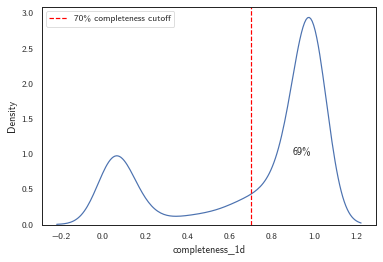

In [28]:
sns.kdeplot(data=dc_agg, x='completeness_1d')
plt.axvline(0.7, ls='--', color='red', label='70% completeness cutoff')
plt.text(0.9,1, '{:.0f}%'.format((dc_agg['completeness_1d'] >= 0.7).sum()/dc_agg['completeness_1d'].count()*100))
plt.legend()
plt.show()

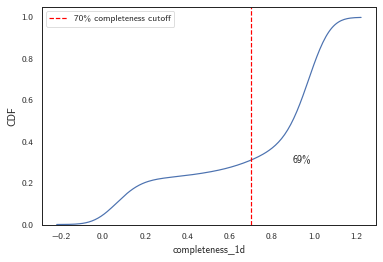

In [29]:
sns.kdeplot(data=dc_agg, x='completeness_1d', cumulative=True)
plt.axvline(0.7, ls='--', color='red', label='70% completeness cutoff')
plt.text(0.9,0.3, '{:.0f}%'.format((dc_agg['completeness_1d'] >= 0.7).sum()/dc_agg['completeness_1d'].count()*100))
plt.legend()
plt.ylabel('CDF')
plt.savefig(SAVE_PATH+'completeness_cutoff_cdf.png', dpi=300, bbox_inches='tight')
plt.show()

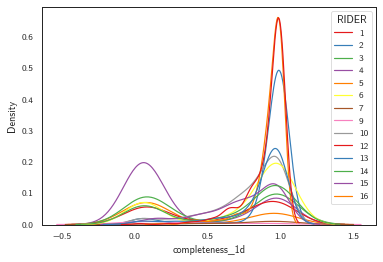

In [30]:
sns.kdeplot(data=dc_agg, x='completeness_1d', hue='RIDER', palette='Set1') ; plt.show()

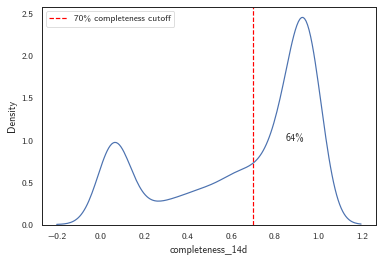

In [31]:
sns.kdeplot(data=dc_agg, x='completeness_14d')
plt.axvline(0.7, ls='--', color='red', label='70% completeness cutoff')
plt.text(0.85,1, '{:.0f}%'.format((dc_agg['completeness_7d'] >= 0.7).sum()/dc_agg['completeness_1d'].count()*100))
plt.legend()
plt.show()

Calendar with glucose availability

In [32]:
dc_avail = pd.merge(dc_agg, season_list, how='right', on=['RIDER', 'date'])\
    .pivot(index='RIDER', columns='date', values='completeness_1d')

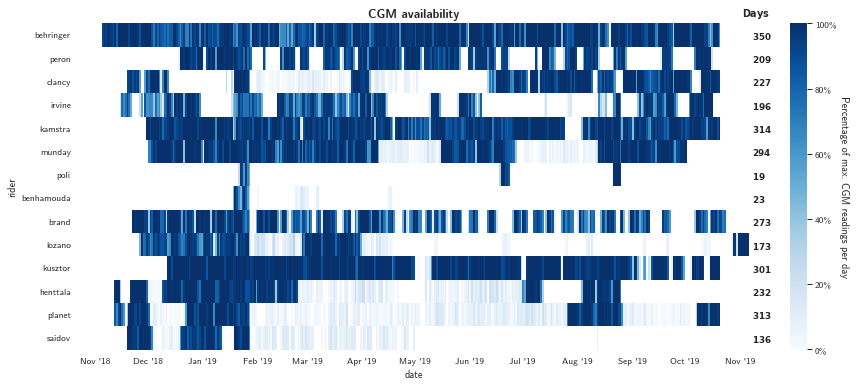

In [33]:
ax = plot_availability(dc_avail, plot_total='count')
plt.title('CGM availability', fontweight='bold', fontsize=12)
savefig('availability/glucose_availability', yticks=ax)

**TODO**: check why!!!

In [34]:
dc[(dc.timestamp.diff() != '5min') & (dc.RIDER.diff() != 1)]

RIDER           timestamp  Glucose Value (mg/dL)     local_timestamp  \
0           1 2018-11-04 23:00:00                  189.0 2018-11-05 00:00:00   
156372      2 2019-05-04 00:00:00                   39.6 2019-05-03 17:00:00   
156456      2 2019-05-03 22:00:00                  241.2 2019-05-04 00:00:00   
156480      2 2019-05-04 07:00:00                  154.8 2019-05-04 00:00:00   
680784      9 2018-11-04 23:00:00                    NaN 2018-11-05 00:00:00   
871992     12 2018-11-25 16:00:00                    NaN 2018-11-26 00:00:00   
920448     12 2019-05-12 23:00:00                  137.0 2019-05-12 16:00:00   
920544     12 2019-05-12 22:00:00                    NaN 2019-05-13 00:00:00   
920556     12 2019-05-13 07:00:00                    NaN 2019-05-13 00:00:00   
968760     12 2019-10-27 21:50:00                   82.8 2019-10-27 22:50:00   
968774     12 2019-10-27 16:00:00                    NaN 2019-10-28 00:00:00   
968844     12 2019-10-27 23:00:00                  100.8 2019-10-28 00:00:00   
971436     12 2019-11-06 00:00:00                   81.0 2019-11-05 18:00:00   

        exercise  recovery   wake  sleep   race  travel       date  
0          False     False  False   True  False   False 2018-11-05  
156372     False     False   True  False  False   False 2019-05-03  
156456     False     False  False   True  False    True 2019-05-04  
156480     False     False  False   True  False    True 2019-05-04  
680784     False     False  False   True  False   False 2018-11-05  
871992     False     False  False   True  False   False 2018-11-26  
920448      True     False   True  False   True   False 2019-05-12  
920544      True     False  False   True   True   False 2019-05-13  
920556     False     False  False   True   True   False 2019-05-13  
968760     False     False   True  False  False    True 2019-10-27  
968774     False     False  False   True  False    True 2019-10-28  
968844     False     False  False   True  False    True 2019-10-28  
971436     False     False   True  False  False   False 2019-11-05

Select data with glucose completeness >= 70% and remove nans from dexcom data

In [35]:
dc = pd.merge(dc, dc_agg[['RIDER', 'date', 'completeness_1d']], on=['RIDER', 'date'], how='left')

In [36]:
dc.loc[dc['completeness_1d'] < 0.7, 'Glucose Value (mg/dL)'] = np.nan
dc = dc.dropna(subset=['Glucose Value (mg/dL)'])

In [37]:
dc_agg = dc_agg[dc_agg['completeness_1d'] >= 0.7]

In [38]:
print("Data available: ")
print("TrainingPeaks: N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom: N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))

Data available: 
TrainingPeaks: N = 14 ; D = 3828
Dexcom: N = 14 ; D = 2120


In [39]:
dc_avail = pd.merge(dc_agg, season_list, how='right', on=['RIDER', 'date'])\
    .pivot(index='RIDER', columns='date', values='completeness_1d')

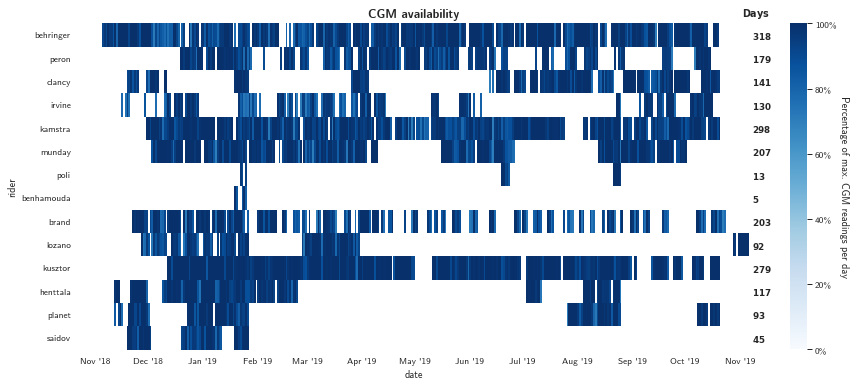

In [40]:
ax = plot_availability(dc_avail, plot_total='count')
plt.title('CGM availability', fontweight='bold', fontsize=12)
savefig('availability/glucose_availability_selectcomp', yticks=ax)

## Descriptives Dexcom

In [41]:
COL = 'Glucose Value (mg/dL)'

In [42]:
SECTIONS = ('wake', 'exercise', 'recovery', 'sleep')

### Glucose distribution (histograms)

All data

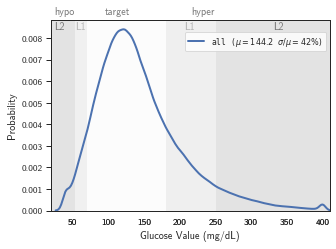

In [43]:
fig, ax0 = plt.subplots(figsize=(5, 3.5))
ax0 = plot_glucose_levels(ax0, color=False)
ax = ax0.twinx()
sns.kdeplot(dc[COL], ax=ax, linewidth=2,
	label=r'all ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
	.format(dc[COL].mean(), dc[COL].std()/dc[COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL)
ax.set_xlabel(COL)
savefig(path='hist/hist_glucose')

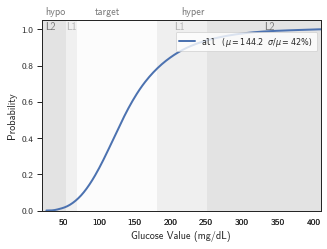

In [44]:
fig, ax0 = plt.subplots(figsize=(5, 3.5))
ax0 = plot_glucose_levels(ax0, color=False)
ax = ax0.twinx()
sns.kdeplot(dc[COL], ax=ax, cumulative=True, linewidth=2,
	label=r'all ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
	.format(dc[COL].mean(), dc[COL].std()/dc[COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL)
ax.set_xlabel(COL)
savefig(path='cdf/cdf_glucose')

All, hue: sections

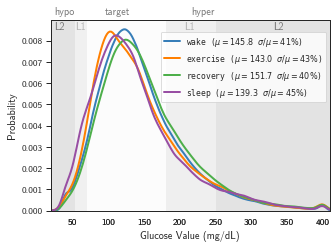

In [45]:
fig, ax0 = plt.subplots(figsize=(5, 3.5))
ax0 = plot_glucose_levels(ax0, color=False)
ax = ax0.twinx()
for k, sec in enumerate(SECTIONS):
	sns.kdeplot(dc[dc[sec]][COL], ax=ax, linewidth=2, color=color_sec[sec],
		label=sec+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'.format(dc[dc[sec]][COL].mean(), dc[dc[sec]][COL].std()/dc[dc[sec]][COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL)
savefig(path='hist/hist_glucose_sec')

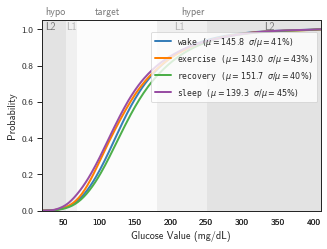

In [46]:
fig, ax0 = plt.subplots(figsize=(5, 3.5))
ax0 = plot_glucose_levels(ax0, color=False)
ax = ax0.twinx()
for k, sec in enumerate(SECTIONS):
	sns.kdeplot(dc[dc[sec]][COL], ax=ax, cumulative=True, linewidth=2, color=color_sec[sec],
		label=sec+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'.format(dc[dc[sec]][COL].mean(), dc[dc[sec]][COL].std()/dc[dc[sec]][COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL)
savefig(path='cdf/cdf_glucose_sec')

Individual athletes, hue: sections

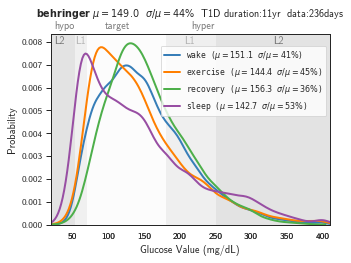

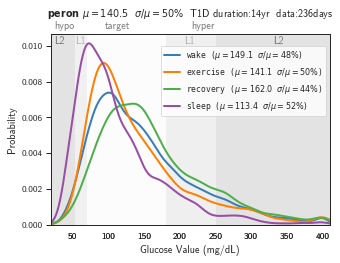

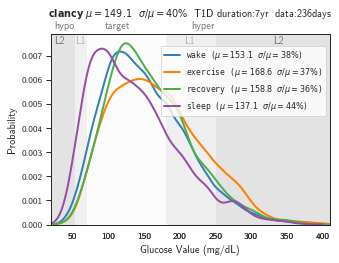

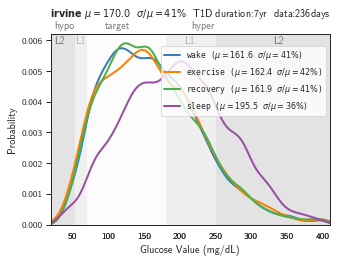

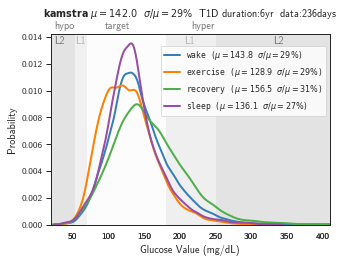

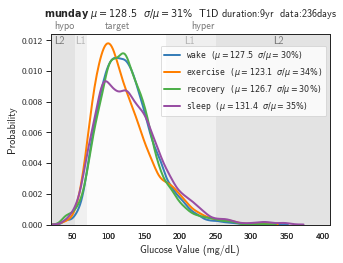

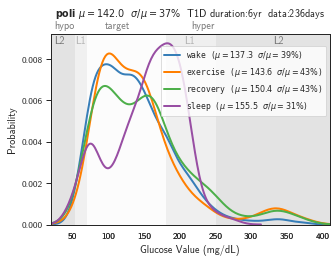

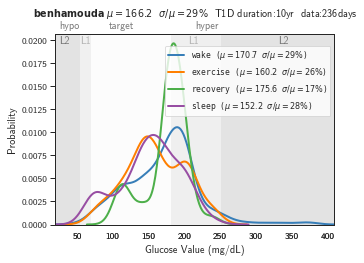

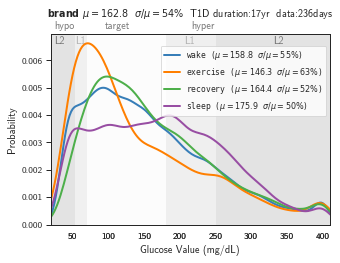

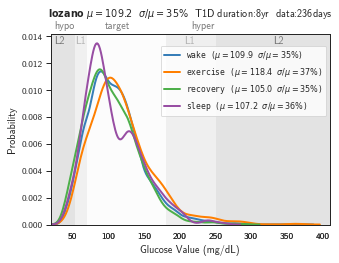

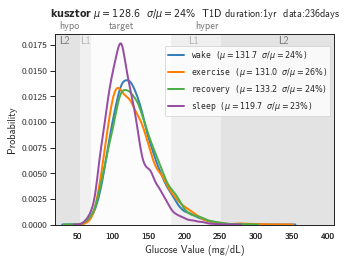

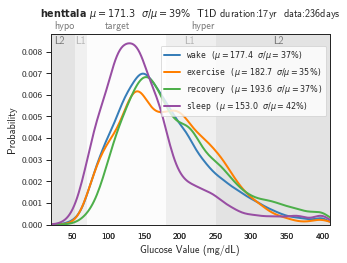

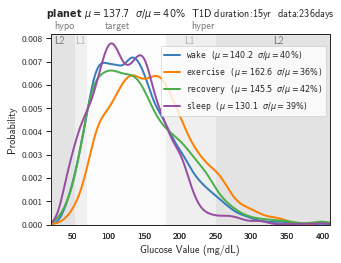

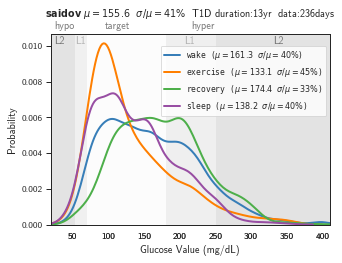

In [47]:
for i in ATHLETES:
	fig, ax0 = plt.subplots(figsize=(5, 3.5))
	ax0 = plot_glucose_levels(ax0, color=False)
	ax = ax0.twinx()
	
	for k, sec in enumerate(SECTIONS):
		sns.kdeplot(dc.loc[dc[sec] & (dc.RIDER == i), COL], ax=ax, linewidth=2, color=color_sec[sec],
			label=sec+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
			.format(dc.loc[dc[sec] & (dc.RIDER == i), COL].mean(), 
					dc.loc[dc[sec] & (dc.RIDER == i), COL].std()/dc.loc[dc[sec] & (dc.RIDER == i), COL].mean()*100))
	plot_hist_glucose_settings(ax, ax0, COL)
	title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(dc[dc.RIDER == i][COL].mean(),
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				len(dc_agg.loc[i]))
	savefig(path='hist/hist_glucose_rider', i=i, title=title, y=1.06)

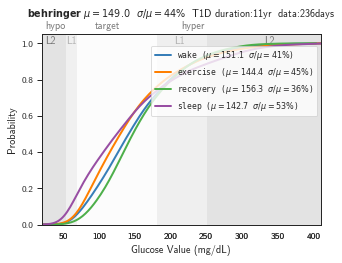

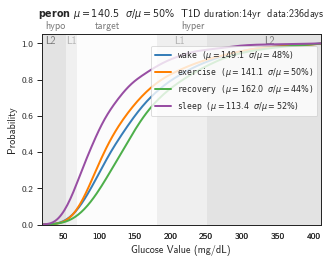

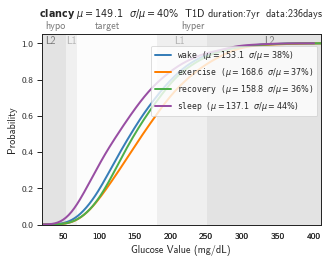

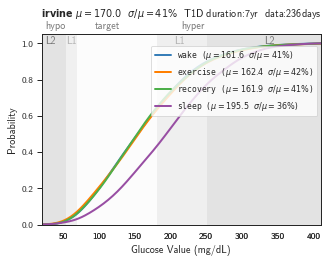

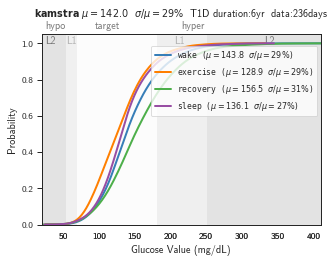

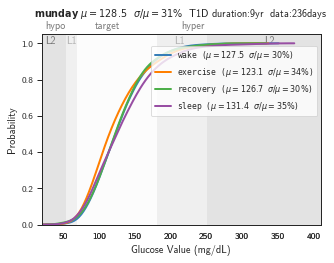

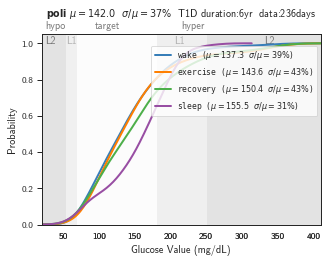

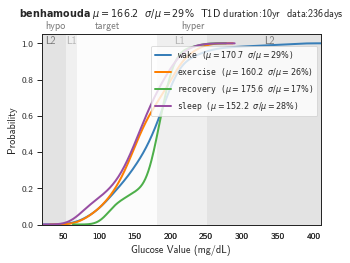

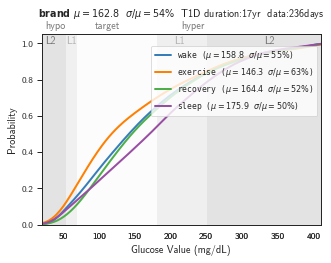

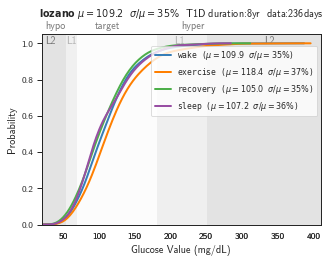

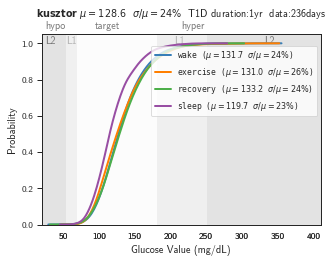

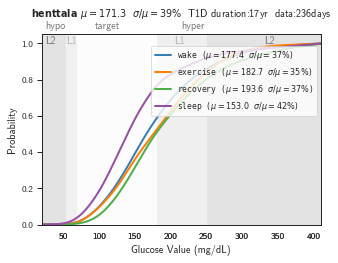

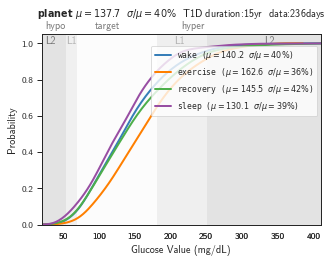

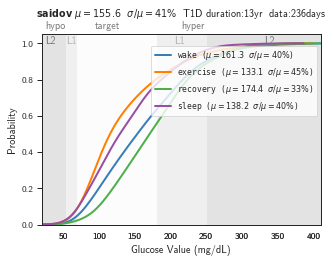

In [48]:
for i in ATHLETES:
	fig, ax0 = plt.subplots(figsize=(5, 3.5))
	ax0 = plot_glucose_levels(ax0, color=False)
	ax = ax0.twinx()
	
	for k, sec in enumerate(SECTIONS):
		sns.kdeplot(dc.loc[dc[sec] & (dc.RIDER == i), COL], ax=ax, cumulative=True, 
			linewidth=2, color=color_sec[sec],
			label=sec+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
			.format(dc.loc[dc[sec] & (dc.RIDER == i), COL].mean(), 
					dc.loc[dc[sec] & (dc.RIDER == i), COL].std()/dc.loc[dc[sec] & (dc.RIDER == i), COL].mean()*100))
	plot_hist_glucose_settings(ax, ax0, COL)
	title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(dc[dc.RIDER == i][COL].mean(),
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				len(dc_agg.loc[i]))
	savefig(path='cdf/cdf_glucose_rider', i=i, title=title, y=1.06)

All, hue: athletes

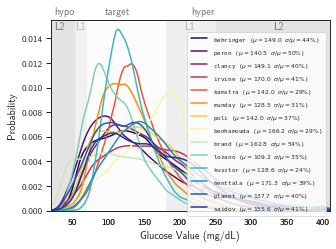

In [49]:
fig, ax0 = plt.subplots(figsize=(5, 3.5))
ax0 = plot_glucose_levels(ax0, color=False)
ax = ax0.twinx()
for c, i in enumerate(ATHLETES):
	sns.kdeplot(dc[dc.RIDER == i][COL], ax=ax, 
		linewidth=1.5, color=palette_ath[c], alpha=.8,
		label=str(i)+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
		.format(dc[dc.RIDER == i][COL].mean(), 
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL)
savefig(path='hist/hist_glucose_riders', legend=ax.get_legend().get_texts())

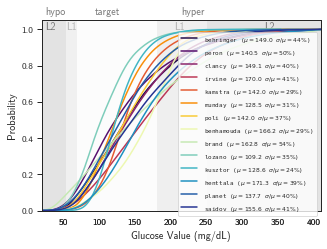

In [50]:
fig, ax0 = plt.subplots(figsize=(5, 3.5))
ax0 = plot_glucose_levels(ax0, color=False)
ax = ax0.twinx()
for c, i in enumerate(ATHLETES):
	sns.kdeplot(dc[dc.RIDER == i][COL], ax=ax, cumulative=True,
		linewidth=1.5, color=palette_ath[c], alpha=.8,
		label=str(i)+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
		.format(dc[dc.RIDER == i][COL].mean(), 
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL)
savefig(path='cdf/cdf_glucose_riders', legend=ax.get_legend().get_texts())

Sections individually, hue: athletes

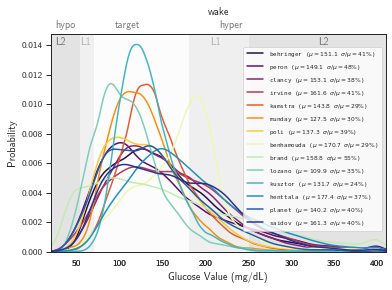

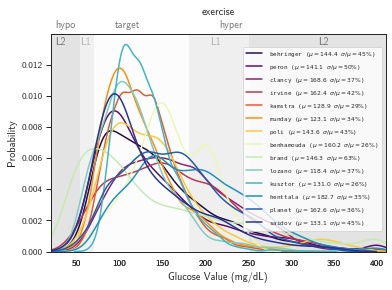

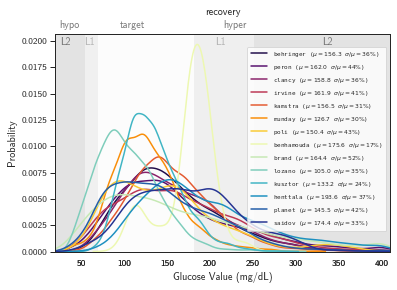

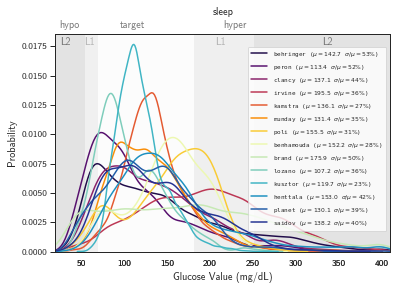

In [51]:
for k, sec in enumerate(SECTIONS):
	fig, ax0 = plt.subplots()
	ax0 = plot_glucose_levels(ax0, color=False)
	ax = ax0.twinx()
	for c, i in enumerate(ATHLETES):
		sns.kdeplot(dc.loc[dc[sec] & (dc.RIDER == i), COL], ax=ax, 
			linewidth=1.5, color=palette_ath[c], alpha=.8,
			label=str(i)+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
			.format(dc.loc[dc[sec] & (dc.RIDER == i), COL].mean(), 
					dc.loc[dc[sec] & (dc.RIDER == i), COL].std()/dc.loc[dc[sec] & (dc.RIDER == i), COL].mean()*100))
	plot_hist_glucose_settings(ax, ax0, COL)
	plt.title(sec, y=1.06)
	savefig(path='hist/hist_glucose_sec', i=sec, legend=ax.get_legend().get_texts())

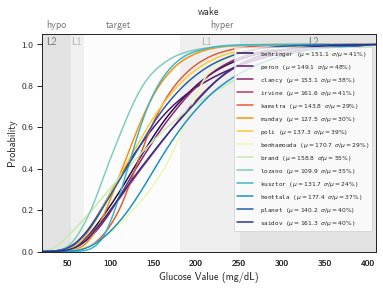

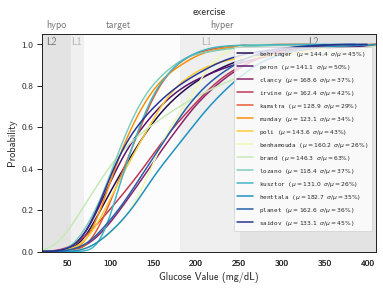

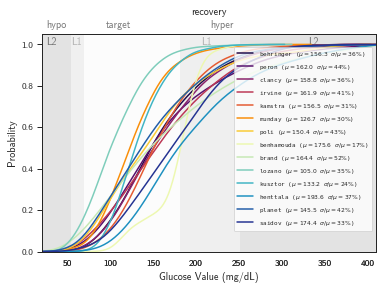

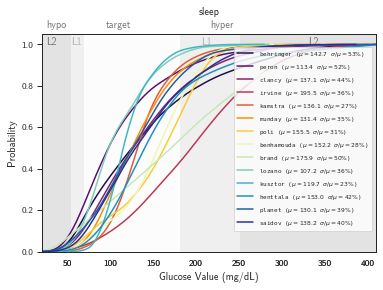

In [52]:
for k, sec in enumerate(SECTIONS):
	fig, ax0 = plt.subplots()
	ax0 = plot_glucose_levels(ax0, color=False)
	ax = ax0.twinx()
	for c, i in enumerate(ATHLETES):
		sns.kdeplot(dc.loc[dc[sec] & (dc.RIDER == i), COL], ax=ax, 
			cumulative=True, linewidth=1.5, color=palette_ath[c], alpha=.8,
			label=str(i)+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
			.format(dc.loc[dc[sec] & (dc.RIDER == i), COL].mean(), 
					dc.loc[dc[sec] & (dc.RIDER == i), COL].std()/dc.loc[dc[sec] & (dc.RIDER == i), COL].mean()*100))
	plot_hist_glucose_settings(ax, ax0, COL)
	plt.title(sec, y=1.06)
	savefig(path='cdf/cdf_glucose_sec', i=sec, legend=ax.get_legend().get_texts())

**CONCLUSION** : Large differences among athletes

### Glucose time in level (barcharts)

In [196]:
def get_percinlevel(dc, col='Glucose Value (mg/dL)'):
	return {level: ((dc[col] >= lmin) & (dc[col] <= lmax)).sum() / len(dc)*100 for level, (lmin, lmax) in glucose_levels.items()}

In [197]:
legend_elements = [Patch(facecolor=c, edgecolor='white', hatch=h, label=l) \
					for c, l, h in zip(sns.diverging_palette(10, 10, s=0, n=5), 
									   list(glucose_levels.keys())[::-1], 
									   ('///', '///', None, '\\\\\\', '\\\\\\'))] 

colors = [dict(zip(['h_neg', 'h_pos', 'l', 's'], [c[0]*360, c[0]*360, c[1]*100, c[2]*100])) \
			for c in [rgb_to_hls(*j) for j in color_sec.values()]]

All, hue: stages

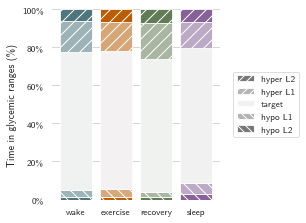

In [198]:
# TODO: now it is dominated by athletes that have the most data, 
# we should calculate it for riders individually and then average
fig, ax = plt.subplots(figsize=(3, 3.5))
for k, sec in enumerate(SECTIONS):
	pil = get_percinlevel(dc[dc[sec]])
	plot_bar(pil, x=k, colors=colors[k])

plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
plt.xticks(np.arange(len(SECTIONS)), SECTIONS)
plt.ylim((0,100))
plt.ylabel('Time in glycemic ranges (%)')

ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.5, 0.5))
ax.yaxis.grid(True)
sns.despine(left=True, bottom=True, right=True)
savefig('time_in_zone/time_in_glucoselevel')

Individual athletes, hue: stages

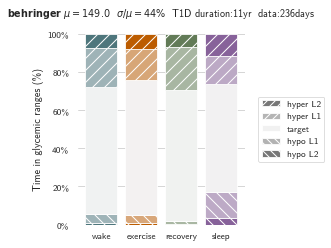

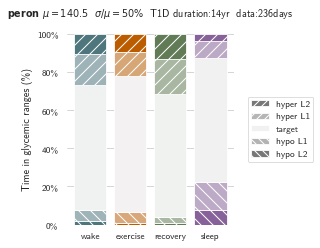

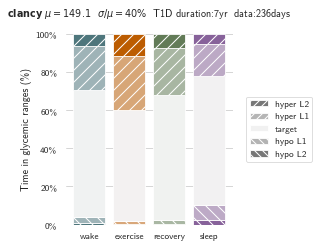

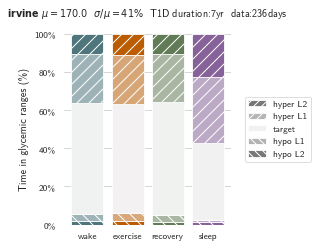

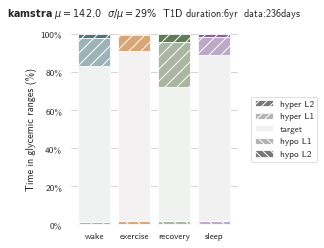

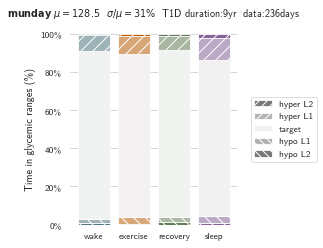

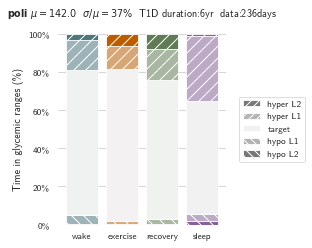

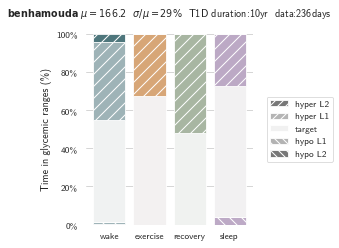

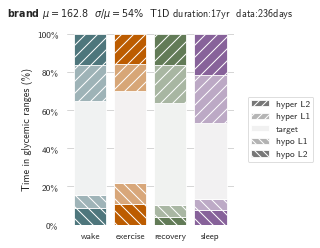

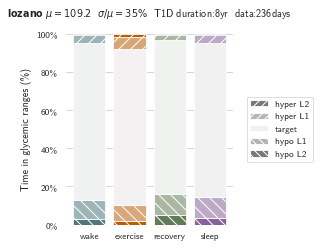

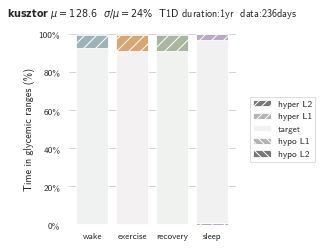

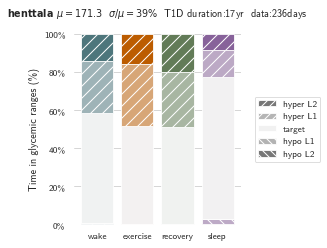

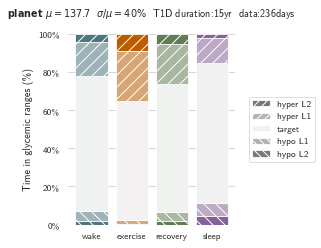

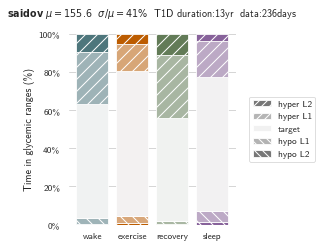

In [199]:
# TODO: check if calculation of perc_in_level is now correct!! (irvine looks weird!)
for i in ATHLETES:
	fig, ax = plt.subplots(figsize=(3, 3.5))
	for k, sec in enumerate(SECTIONS):
		pil = get_percinlevel(dc[dc[sec] & (dc.RIDER == i)])
		plot_bar(pil, x=k, colors=colors[k])

	plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
	plt.xticks(np.arange(len(SECTIONS)), SECTIONS)
	plt.ylim((0,100))
	plt.ylabel('Time in glycemic ranges (%)')

	ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.5, 0.5))
	ax.yaxis.grid(True)
	sns.despine(left=True, bottom=True, right=True)
    
	title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(dc[dc.RIDER == i][COL].mean(),
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				len(dc_agg.loc[i]))
	savefig(path='time_in_zone/time_in_glucoselevel', i=i, title=title, y=1.06)

All, hue: athletes

In [200]:
colors = colors = [dict(zip(['h_neg', 'h_pos', 'l', 's'], [c[0]*360, c[0]*360, c[1]*100, c[2]*100])) \
			for c in [rgb_to_hls(*j) for j in palette_ath]]

In [201]:
# TODO: to plot.py
def plot_bar(data, x, width=.8, colors=dict(h_neg=10, h_pos=10, s=0, l=50), ax=plt, plot_numbers=False, duration=None):
	hatch = ('\\\\', '\\\\', None, '//', '//')
	color_palette = sns.diverging_palette(**colors, n=5)
	bottom = 0
	for sec, (label, y) in enumerate(data.items()):
		c = ax.bar(x=x, height=y, width=width, bottom=bottom, color=color_palette[sec], hatch=hatch[sec])
		bottom += y
		if plot_numbers and y >= 4:
			if sec == 2:
				ax.bar_label(c, fmt='%.0f', label_type='center', color='gray')
			elif plot_numbers == 'full':
				ax.bar_label(c, fmt='%.0f', label_type='center', fontweight='black', color='white')
	if duration:
		ax.text(x, -8, duration, ha='center')

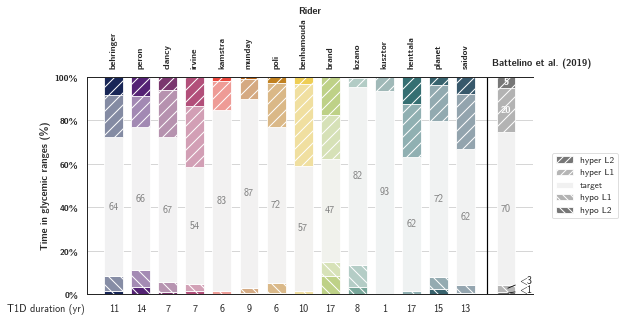

In [206]:
fig, ax = plt.subplots(figsize=(8,4))
for n, i in enumerate(ATHLETES):
    pil = get_percinlevel(dc[dc.RIDER == i])
    plot_bar(pil, x=n, width=.7, colors=colors[n], duration=info['diabetes_duration'][i], plot_numbers='half')

# plot reference
plt.plot((n+1-0.2, n+1-0.2), (0, 100), color='black')
plot_bar({'hypo L2':1.2, 'hypo L1':3.2, 'target':70.2, 'hyper L1':20.2, 'hyper L2':5.2}, 
         x=n+1.5, width=.7, plot_numbers='full')
plt.annotate('<3', xy=(n+1.5, 2.5), xytext=(n+2, 5), ha='left', arrowprops=dict(arrowstyle="-", color='black'))
plt.annotate('<1', xy=(n+1.5, 0.5), xytext=(n+2, 0.5), ha='left', arrowprops=dict(arrowstyle="-", color='black'))
plt.text(n+1, 105, 'Battelino et al. (2019)', fontweight='bold', ha='left')

# diabetes duration on bottom
plt.text(-2.5, -8, 'T1D duration (yr)', ha='center')

# ticks and axes
plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)], weight='bold')
plt.xticks(np.arange(len(ATHLETES)), ATHLETES, weight='bold')
plt.xlim((-1, 15.5))
plt.ylim((0,100))
plt.ylabel('Time in glycemic ranges (%)', weight='bold')
plt.xlabel('Rider', weight='bold')
ax.xaxis.set_label_position('top')
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top=False, labeltop=True)

ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.2, 0.5))
ax.yaxis.grid(True)
sns.despine(bottom=False, right=True, top=False)

savefig('time_in_zone/time_in_glucoselevel_riders', xticks=ax)

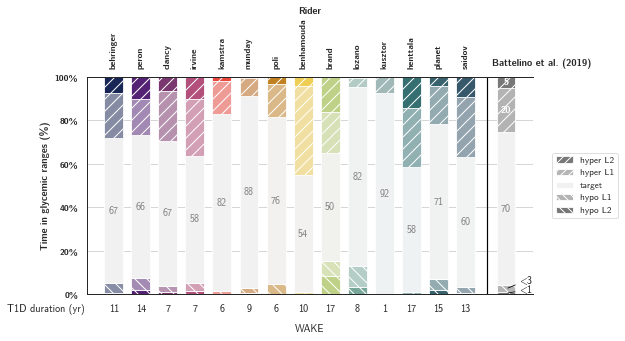

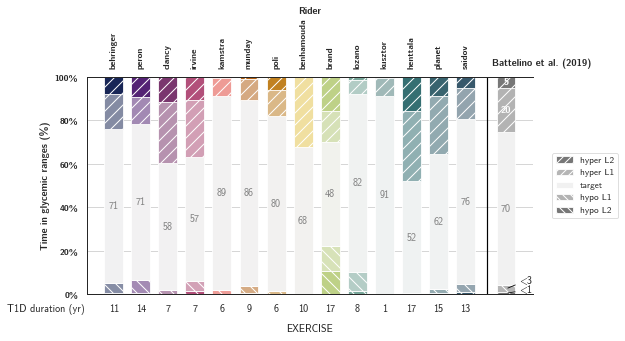

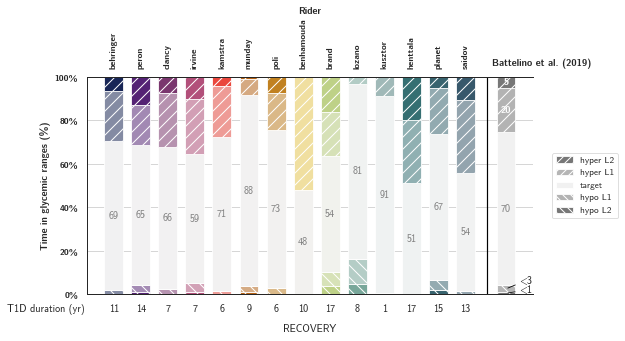

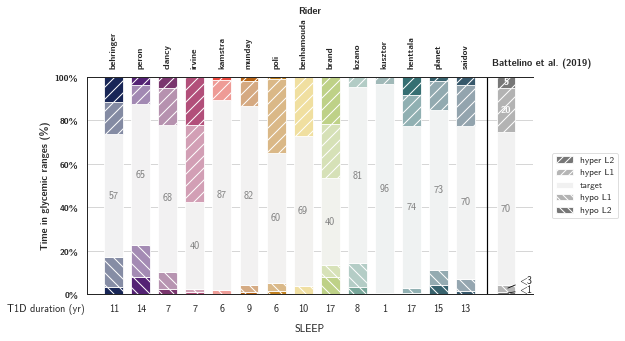

In [207]:
for sec in SECTIONS:
    fig, ax = plt.subplots(figsize=(8,4))
    for n, i in enumerate(ATHLETES):
        pil = get_percinlevel(dc[(dc.RIDER == i) & dc[sec]])
        plot_bar(pil, x=n, width=.7, colors=colors[n], duration=info['diabetes_duration'][i], plot_numbers='half')

    # plot reference
    plt.plot((n+1-0.2, n+1-0.2), (0, 100), color='black')
    plot_bar({'hypo L2':1.2, 'hypo L1':3.2, 'target':70.2, 'hyper L1':20.2, 'hyper L2':5.2}, 
             x=n+1.5, width=.7, plot_numbers='full')
    plt.annotate('<3', xy=(n+1.5, 2.5), xytext=(n+2, 5), ha='left', arrowprops=dict(arrowstyle="-", color='black'))
    plt.annotate('<1', xy=(n+1.5, 0.5), xytext=(n+2, 0.5), ha='left', arrowprops=dict(arrowstyle="-", color='black'))
    plt.text(n+1, 105, 'Battelino et al. (2019)', fontweight='bold', ha='left')

    # diabetes duration on bottom
    plt.text(-2.5, -8, 'T1D duration (yr)', ha='center')

    # ticks and axes
    plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)], weight='bold')
    plt.xticks(np.arange(len(ATHLETES)), ATHLETES, weight='bold')
    plt.xlim((-1, 15.5))
    plt.ylim((0,100))
    plt.ylabel('Time in glycemic ranges (%)', weight='bold')
    plt.xlabel('Rider', weight='bold')
    ax.xaxis.set_label_position('top')
    plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top=False, labeltop=True)

    ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.2, 0.5))
    ax.yaxis.grid(True)
    sns.despine(bottom=False, right=True, top=False)

    plt.title(sec.upper(), y=-0.2)
    savefig('time_in_zone/time_in_glucoselevel_riders_%s'%sec, xticks=ax)

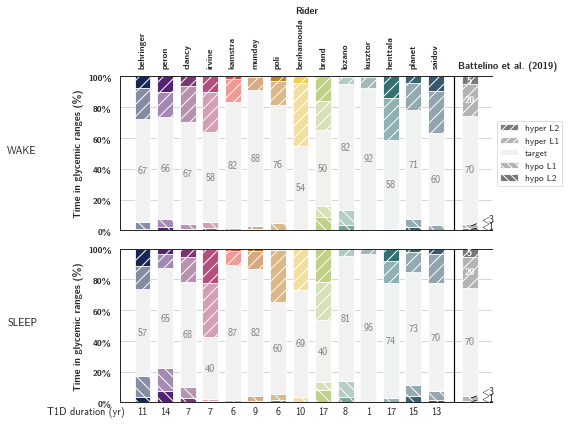

In [208]:
fig, axs = plt.subplots(2,1, figsize=(8,6), sharex=True, tight_layout=True)
for ax, sec in zip(axs, ('wake', 'sleep')):
    for n, i in enumerate(ATHLETES):
        pil = get_percinlevel(dc[(dc.RIDER == i) & dc[sec]])
        duration = info['diabetes_duration'][i] if sec == 'sleep' else None
        plot_bar(pil, ax=ax, x=n, width=.7, colors=colors[n], duration=duration, plot_numbers='half')

    # plot reference
    ax.plot((n+1-0.2, n+1-0.2), (0, 100), color='black')
    plot_bar({'hypo L2':1.2, 'hypo L1':3.2, 'target':70.2, 'hyper L1':20.2, 'hyper L2':5.2}, 
             ax=ax, x=n+1.5, width=.7, plot_numbers='full')
    ax.annotate('<3', xy=(n+1.5, 2.5), xytext=(n+2, 5), ha='left', arrowprops=dict(arrowstyle="-", color='black'))
    ax.annotate('<1', xy=(n+1.5, 0.5), xytext=(n+2, 0.5), ha='left', arrowprops=dict(arrowstyle="-", color='black'))

    # ticks and axes
    ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)], weight='bold')
    ax.set_xlim((-1, 15.5))
    ax.set_ylim((0,100))
    ax.set_ylabel('Time in glycemic ranges (%)', weight='bold')
    ax.yaxis.grid(True)
        
    ax.text(-6, 50, sec.upper())

# diabetes duration on bottom
axs[1].text(-2.5, -8, 'T1D duration (yr)', ha='center')

# reference
axs[0].text(n+1, 105, 'Battelino et al. (2019)', fontweight='bold', ha='left')

# ticks
axs[0].set_xticks(np.arange(len(ATHLETES)), ATHLETES, weight='bold')
axs[0].set_xlabel('Rider', weight='bold')
axs[0].xaxis.set_label_position('top')
axs[0].tick_params(axis='both', which='major', labelbottom = False, bottom=False, top=False, labeltop=True)
axs[1].tick_params(axis='both', which='major', labelbottom = False, bottom=False, top=False, labeltop=False)

axs[0].legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.2, 0.5))
sns.despine(bottom=False, right=True, top=False)

savefig('time_in_zone/time_in_glucoselevel_riders_daynight', xticks=axs[0])

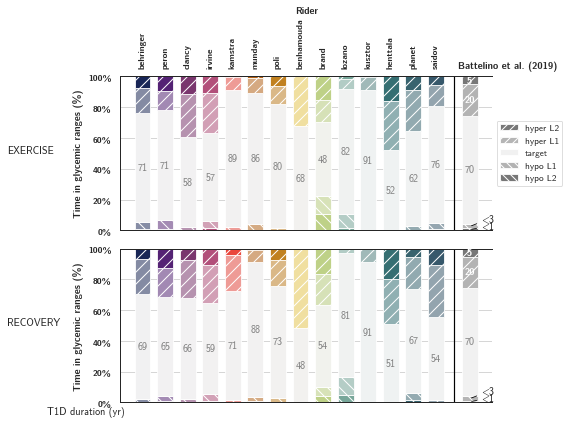

In [209]:
fig, axs = plt.subplots(2,1, figsize=(8,6), sharex=True, tight_layout=True)
for ax, sec in zip(axs, ('exercise', 'recovery')):
    for n, i in enumerate(ATHLETES):
        pil = get_percinlevel(dc[(dc.RIDER == i) & dc[sec]])
        duration = info['diabetes_duration'][i] if sec == 'sleep' else None
        plot_bar(pil, ax=ax, x=n, width=.7, colors=colors[n], duration=duration, plot_numbers='half')

    # plot reference
    ax.plot((n+1-0.2, n+1-0.2), (0, 100), color='black')
    plot_bar({'hypo L2':1.2, 'hypo L1':3.2, 'target':70.2, 'hyper L1':20.2, 'hyper L2':5.2}, 
             ax=ax, x=n+1.5, width=.7, plot_numbers='full')
    ax.annotate('<3', xy=(n+1.5, 2.5), xytext=(n+2, 5), ha='left', arrowprops=dict(arrowstyle="-", color='black'))
    ax.annotate('<1', xy=(n+1.5, 0.5), xytext=(n+2, 0.5), ha='left', arrowprops=dict(arrowstyle="-", color='black'))

    # ticks and axes
    ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)], weight='bold')
    ax.set_xlim((-1, 15.5))
    ax.set_ylim((0,100))
    ax.set_ylabel('Time in glycemic ranges (%)', weight='bold')
    ax.yaxis.grid(True)
        
    ax.text(-6, 50, sec.upper())

# diabetes duration on bottom
axs[1].text(-2.5, -8, 'T1D duration (yr)', ha='center')

# reference
axs[0].text(n+1, 105, 'Battelino et al. (2019)', fontweight='bold', ha='left')

# ticks
axs[0].set_xticks(np.arange(len(ATHLETES)), ATHLETES, weight='bold')
axs[0].set_xlabel('Rider', weight='bold')
axs[0].xaxis.set_label_position('top')
axs[0].tick_params(axis='both', which='major', labelbottom = False, bottom=False, top=False, labeltop=True)
axs[1].tick_params(axis='both', which='major', labelbottom = False, bottom=False, top=False, labeltop=False)

axs[0].legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.2, 0.5))
sns.despine(bottom=False, right=True, top=False)

savefig('time_in_zone/time_in_glucoselevel_riders_exerciserecovery', xticks=axs[0])

/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_sca

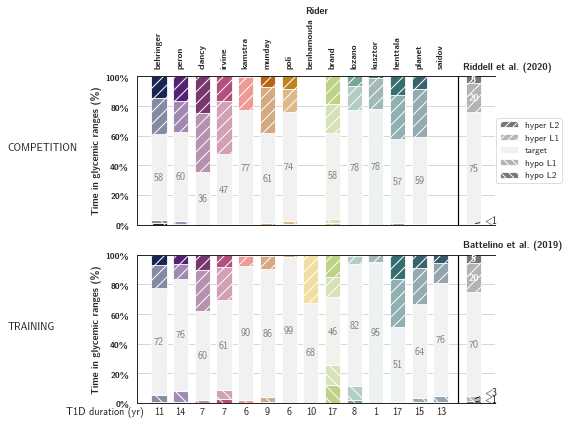

In [214]:
fig, axs = plt.subplots(2,1, figsize=(8,6), sharex=True, tight_layout=True)
MASK = {'competition': dc['race'] & dc['exercise'],
        'training'   : ~dc['race'] & dc['exercise']}
for ax, (sec, mask) in zip(axs, MASK.items()):
    for n, i in enumerate(ATHLETES):
        pil = get_percinlevel(dc[(dc.RIDER == i) & mask])
        duration = info['diabetes_duration'][i] if sec == 'training' else None
        plot_bar(pil, ax=ax, x=n, width=.7, colors=colors[n], duration=duration, plot_numbers='half')

    # plot reference
    if sec == 'competition':
        ax.plot((n+1-0.2, n+1-0.2), (0, 100), color='black')
        plot_bar({'hypo L2':0, 'hypo L1':0.7, 'target':75.2, 'hyper L1':19.55, 'hyper L2':4.55}, 
                 ax=ax, x=n+1.5, width=.7, plot_numbers='full')
        ax.annotate('<1', xy=(n+1.5, 0.5), xytext=(n+2, 0.5), ha='left', arrowprops=dict(arrowstyle="-", color='black'))
        ax.text(n+1, 105, 'Riddell et al. (2020)', fontweight='bold', ha='left')
    else:
        ax.plot((n+1-0.2, n+1-0.2), (0, 100), color='black')
        plot_bar({'hypo L2':1.2, 'hypo L1':3.2, 'target':70.2, 'hyper L1':20.2, 'hyper L2':5.2}, 
                 ax=ax, x=n+1.5, width=.7, plot_numbers='full')
        ax.annotate('<3', xy=(n+1.5, 2.5), xytext=(n+2, 5), ha='left', arrowprops=dict(arrowstyle="-", color='black'))
        ax.annotate('<1', xy=(n+1.5, 0.5), xytext=(n+2, 0.5), ha='left', arrowprops=dict(arrowstyle="-", color='black'))
        ax.text(n+1, 105, 'Battelino et al. (2019)', fontweight='bold', ha='left')

    # ticks and axes
    ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)], weight='bold')
    ax.set_xlim((-1, 15.5))
    ax.set_ylim((0,100))
    ax.set_ylabel('Time in glycemic ranges (%)', weight='bold')
    ax.yaxis.grid(True)
        
    ax.text(-7, 50, sec.upper())

# diabetes duration on bottom
axs[1].text(-2.5, -8, 'T1D duration (yr)', ha='center')

# ticks
axs[0].set_xticks(np.arange(len(ATHLETES)), ATHLETES, weight='bold')
axs[0].set_xlabel('Rider', weight='bold')
axs[0].xaxis.set_label_position('top')
axs[0].tick_params(axis='both', which='major', labelbottom = False, bottom=False, top=False, labeltop=True)
axs[1].tick_params(axis='both', which='major', labelbottom = False, bottom=False, top=False, labeltop=False)

axs[0].legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.2, 0.5))
sns.despine(bottom=False, right=True, top=False)

savefig('time_in_zone/time_in_glucoselevel_riders_competitiontrain', xticks=axs[0])

**CONCLUSION** : Large differences among athletes

#### Race vs. no race

In [215]:
# race vs no race
colors = [dict(zip(['h_neg', 'h_pos', 'l', 's'], [c[0]*360, c[0]*360, c[1]*100, c[2]*100])) \
			for c in [rgb_to_hls(*j) for j in color_race.values()]]

All, hue: race

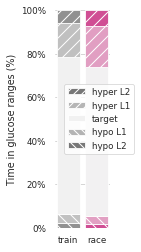

In [69]:
fig, ax = plt.subplots(figsize=(1,4))
for k, b in enumerate([False, True]):
	pil = get_percinlevel(dc[dc['race'] == b])
	plot_bar(pil, x=k, colors=colors[k])

plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
plt.xticks(np.arange(2), [j for j in color_race.keys()])
plt.ylim((0,100))
plt.ylabel('Time in glucose ranges (%)')

ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.5, 0.5))
ax.yaxis.grid(True)
sns.despine(left=True, bottom=True, right=True)

savefig('time_in_zone/time_in_glucoselevel_race')

Individual athletes, hue: race

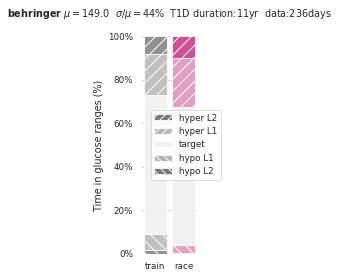

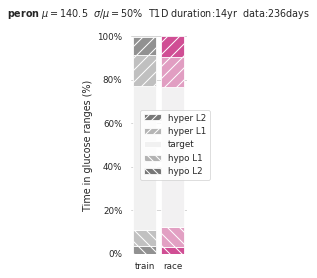

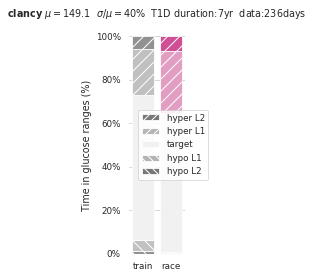

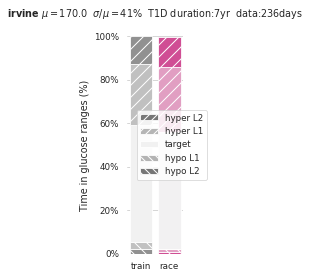

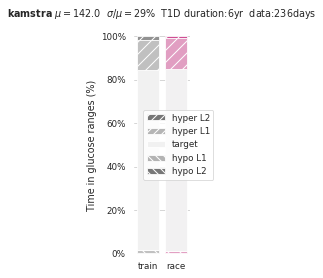

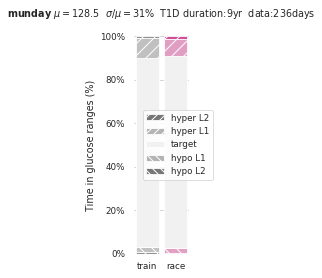

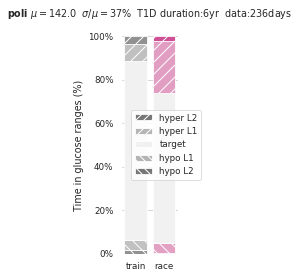

/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  


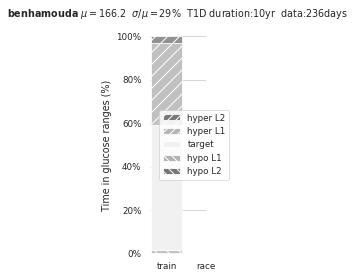

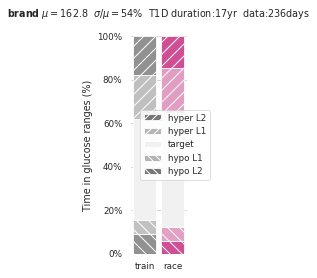

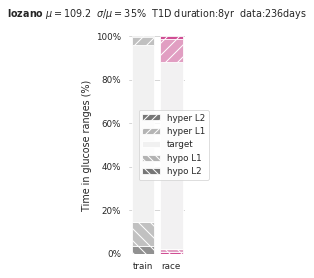

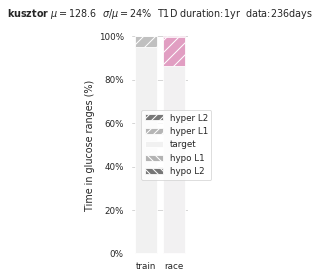

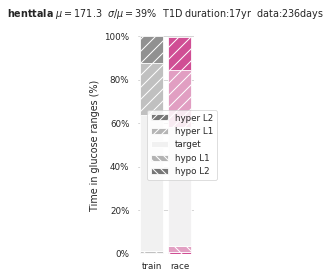

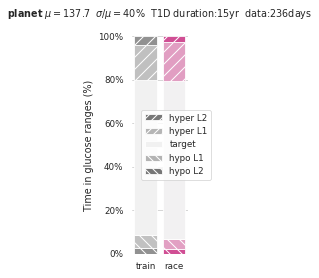

/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  


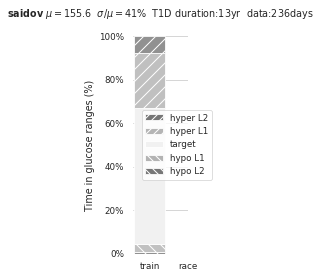

In [70]:
for i in ATHLETES:
	fig, ax = plt.subplots(figsize=(1,4))
	for k, b in enumerate([False, True]):
		pil = get_percinlevel(dc[(dc.RIDER == i) & (dc['race'] == b)])
		plot_bar(pil, x=k, colors=colors[k])

	plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
	plt.xticks(np.arange(2), [j for j in color_race.keys()])
	plt.ylim((0,100))
	plt.ylabel('Time in glucose ranges (%)')

	ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.5, 0.5))
	ax.yaxis.grid(True)
	sns.despine(left=True, bottom=True, right=True)

	title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(dc[dc.RIDER == i][COL].mean(),
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				len(dc_agg.loc[i]))
	savefig(path='time_in_zone/time_in_glucoselevel_race', i=i, title=title, y=1.06)

### Glucose distribution (boxplots)

In [71]:
kws_box = {'race':	dict(boxprops=dict(color='w', facecolor=color_race['race'], hatch='\\\\\\'),
						 medianprops=dict(color='w', linewidth=2),
						 whiskerprops=dict(color=color_race['race']), capprops=dict(color=color_race['race'])),
		   'train':dict(boxprops=dict(color='w', facecolor=color_race['train'], hatch='///'),
						 medianprops=dict(color='w', linewidth=2),
						 whiskerprops=dict(color=color_race['train']), capprops=dict(color=color_race['train']))}

All, stratify: sections

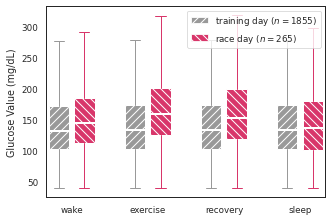

In [72]:
n_nc = len(dc.loc[dc['race'] == False, ['RIDER', 'date']].drop_duplicates())
n_rc = len(dc.loc[dc['race'] == True, ['RIDER', 'date']].drop_duplicates())

fig, ax = plt.subplots(figsize=(5,3.5))
for k, sec in enumerate(SECTIONS):
	plt.boxplot(dc.loc[dc[sec] & dc['race']==False, COL], positions=[k+0.5+k*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['train'])
	plt.boxplot(dc.loc[dc[sec] & dc['race']==True, COL], positions=[k+1.5+k*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['race'])
plt.xticks([1,4,7,10], SECTIONS)
plt.ylabel(COL)
plt.legend(handles=[Patch(facecolor=color_race['train'], edgecolor='white', hatch='///', label='training day'+r' ($n = {:.0f}$)'.format(n_nc)),
					Patch(facecolor=color_race['race'], edgecolor='white', hatch='\\\\\\', label='race day'r' ($n = {:.0f}$)'.format(n_rc))], 
			loc='upper right')
savefig('boxplot/box_glucose_sections')

Individual athletes, stratify: sections

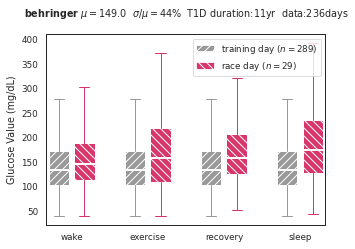

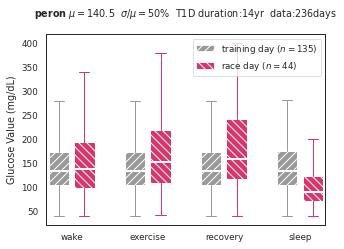

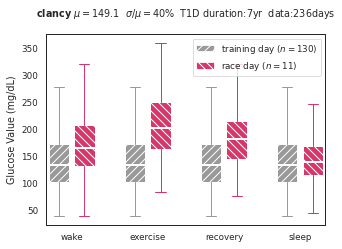

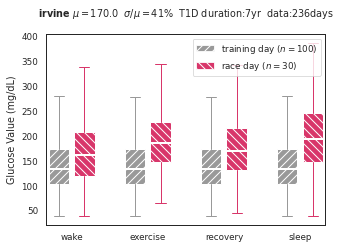

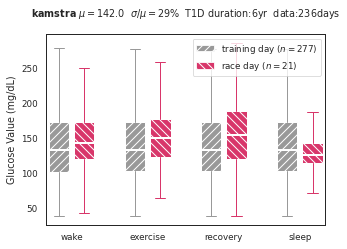

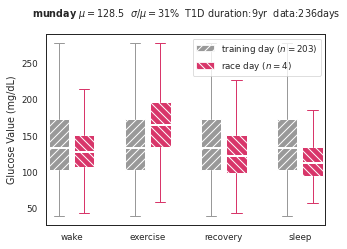

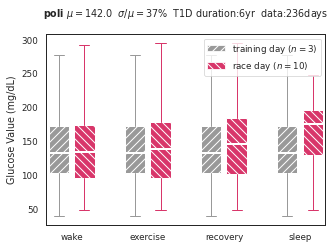

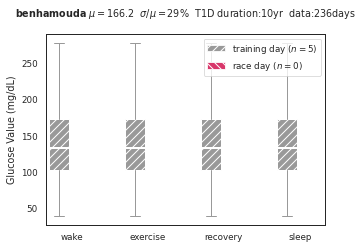

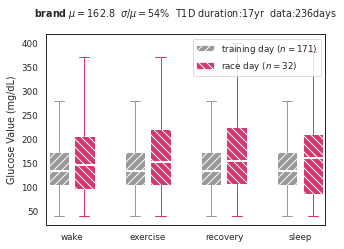

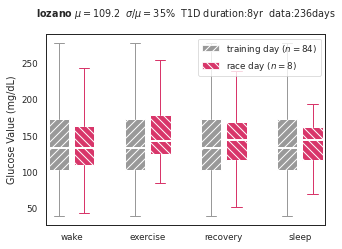

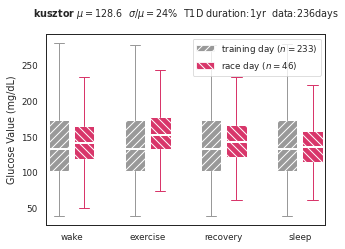

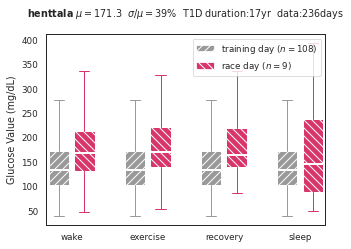

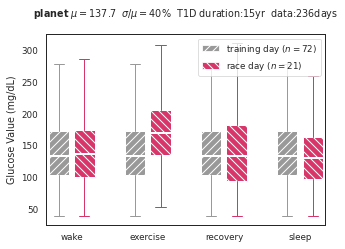

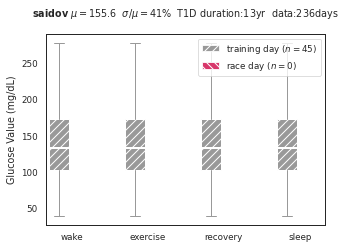

In [73]:
for i in ATHLETES:
	n_nc = len(dc.loc[(dc.RIDER == i) & (dc['race'] == False), 'local_timestamp'].dt.date.unique())
	n_rc = len(dc.loc[(dc.RIDER == i) & (dc['race'] == True), 'local_timestamp'].dt.date.unique())

	fig, ax = plt.subplots(figsize=(5,3.5))
	for k, sec in enumerate(SECTIONS):
		plt.boxplot(dc.loc[(dc.RIDER == i) & dc[sec] & dc['race']==False, COL], positions=[k+0.5+k*2], widths=[0.8],
			patch_artist=True, showfliers=False, **kws_box['train'])
		plt.boxplot(dc.loc[(dc.RIDER == i) & dc[sec] & dc['race']==True, COL], positions=[k+1.5+k*2], widths=[0.8],
			patch_artist=True, showfliers=False, **kws_box['race'])
	plt.xticks([1,4,7,10], SECTIONS)
	plt.ylabel(COL)
	plt.legend(handles=[Patch(facecolor=color_race['train'], edgecolor='white', hatch='///', label='training day'+r' ($n = {:.0f}$)'.format(n_nc)),
						Patch(facecolor=color_race['race'], edgecolor='white', hatch='\\\\\\', label='race day'r' ($n = {:.0f}$)'.format(n_rc))], 
				loc='upper right')

	title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(dc[dc.RIDER == i][COL].mean(),
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				len(dc_agg.loc[i]))
	savefig(path='boxplot/box_glucose_sections', i=i, title=title, y=1.06)

All, stratify: athletes

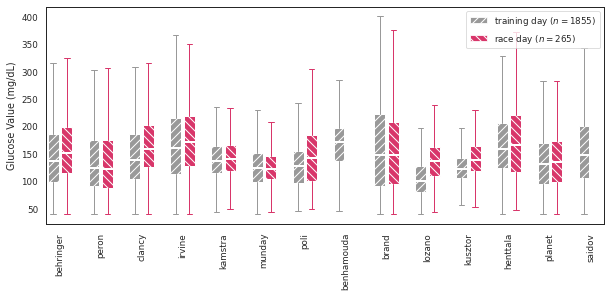

In [74]:
n_nc = len(dc.loc[dc['race'] == False, ['RIDER', 'date']].drop_duplicates())
n_rc = len(dc.loc[dc['race'] == True, ['RIDER', 'date']].drop_duplicates())

# hue: athlete
fig, ax = plt.subplots(figsize=(10,4))
for n, i in enumerate(ATHLETES):
	plt.boxplot(dc.loc[(dc.RIDER == i) & (dc['race'] == False), COL], positions=[n+0.5+n*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['train'])
	plt.boxplot(dc.loc[(dc.RIDER == i) & (dc['race'] == True), COL], positions=[n+1.5+n*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['race'])
plt.ylabel(COL)
plt.legend(handles=[Patch(facecolor=color_race['train'], edgecolor='white', hatch='///', label='training day'+r' ($n = {:.0f}$)'.format(n_nc)),
					Patch(facecolor=color_race['race'], edgecolor='white', hatch='\\\\\\', label='race day'r' ($n = {:.0f}$)'.format(n_rc))], 
			loc='upper right')
plt.xticks(np.arange(1, len(ATHLETES)*3,3), ATHLETES)

savefig('boxplot/box_glucose_riders', xticks=ax)

### Glucose during cycling (longitudinal)

In [216]:
# session id
dc['tid'] = dc.loc[dc['exercise'] != dc['exercise'].shift(), 'exercise'].cumsum()
dc['tid'] = dc['tid'].fillna(method='ffill')

# time within session
dc['t'] = dc.groupby('tid').cumcount() * 5
dc

RIDER           timestamp  Glucose Value (mg/dL)     local_timestamp  \
0            1 2018-11-04 23:00:00                  189.0 2018-11-05 00:00:00   
1            1 2018-11-04 23:05:00                  192.0 2018-11-05 00:05:00   
2            1 2018-11-04 23:10:00                  197.0 2018-11-05 00:10:00   
3            1 2018-11-04 23:15:00                  188.0 2018-11-05 00:15:00   
4            1 2018-11-04 23:20:00                  185.0 2018-11-05 00:20:00   
...        ...                 ...                    ...                 ...   
1267207     16 2019-01-26 22:35:00                  151.0 2019-01-26 23:35:00   
1267208     16 2019-01-26 22:40:00                  135.0 2019-01-26 23:40:00   
1267209     16 2019-01-26 22:45:00                  120.0 2019-01-26 23:45:00   
1267210     16 2019-01-26 22:50:00                  111.0 2019-01-26 23:50:00   
1267211     16 2019-01-26 22:55:00                  107.0 2019-01-26 23:55:00   

         exercise  recovery   wake  sleep   race  travel       date  \
0           False     False  False   True  False   False 2018-11-05   
1           False     False  False   True  False   False 2018-11-05   
2           False     False  False   True  False   False 2018-11-05   
3           False     False  False   True  False   False 2018-11-05   
4           False     False  False   True  False   False 2018-11-05   
...           ...       ...    ...    ...    ...     ...        ...   
1267207     False     False   True  False  False   False 2019-01-26   
1267208     False     False   True  False  False   False 2019-01-26   
1267209     False     False   True  False  False   False 2019-01-26   
1267210     False     False   True  False  False   False 2019-01-26   
1267211     False     False   True  False  False   False 2019-01-26   

         completeness_1d     tid    t  
0               0.920139     0.0    0  
1               0.920139     0.0    5  
2               0.920139     0.0   10  
3               0.920139     0.0   15  
4               0.920139     0.0   20  
...                  ...     ...  ...  
1267207         1.000000  1973.0  830  
1267208         1.000000  1973.0  835  
1267209         1.000000  1973.0  840  
1267210         1.000000  1973.0  845  
1267211         1.000000  1973.0  850  

[578452 rows x 14 columns]

All

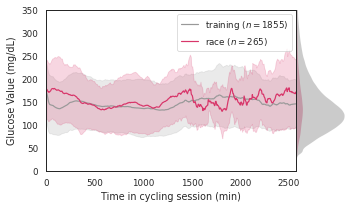

In [76]:
n_nc = len(dc.loc[dc['race'] == False, ['RIDER', 'date']].drop_duplicates())
n_rc = len(dc.loc[dc['race'] == True, ['RIDER', 'date']].drop_duplicates())

t_max = dc.groupby('tid')['t'].max().quantile(0.9) #dc['t'].max()

fig, ax = plt.subplots(1,2, figsize=(5, 3), sharey=True, gridspec_kw={'width_ratios': [5, 1], 'wspace':0}, tight_layout=True)
sns.lineplot(x=dc['t'], y=dc[COL], hue=dc['race'], ci='sd', palette=list(color_race.values()), ax=ax[0])
ax[0].set_xlabel('Time in cycling session (min)')
ax[0].legend(loc='upper right', handles=ax[0].get_legend().get_lines(), 
	labels=['training'+r' ($n = {:.0f}$)'.format(n_nc), 'race'+r' ($n = {:.0f}$)'.format(n_rc)])
sns.kdeplot(data=dc.loc[dc['t'].notna()], y=COL, hue='race', ax=ax[1],
	fill=True, alpha=.5, palette=list(color_race.values()), linewidth=0, legend=False)
sns.despine(bottom=True, right=True, top=True, ax=ax[1])
ax[1].set(xlabel=None, xticks=[])
plt.ylim((0,350))
ax[0].set_xlim((0, t_max))
savefig('time_cycling/glucose_cycling')

Individual athletes

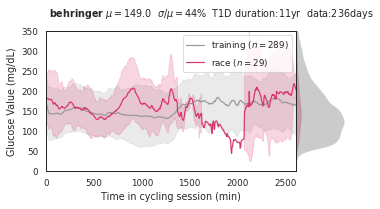

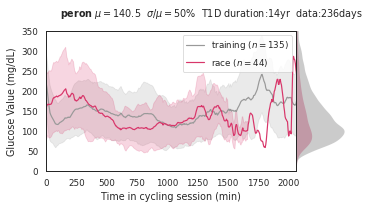

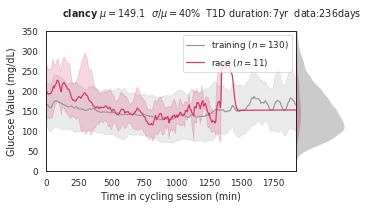

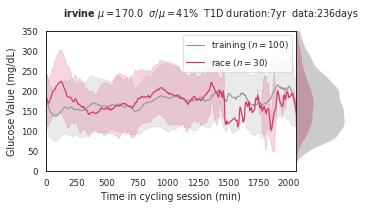

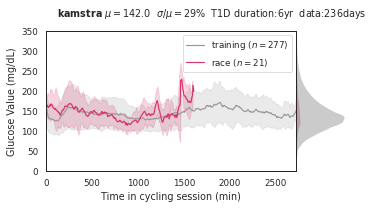

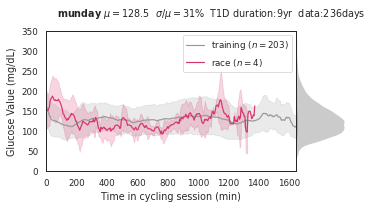

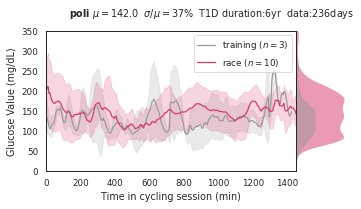

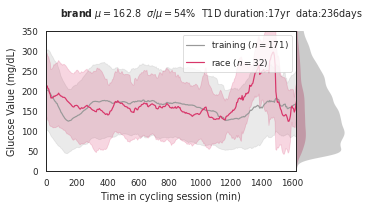

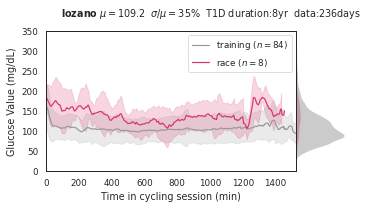

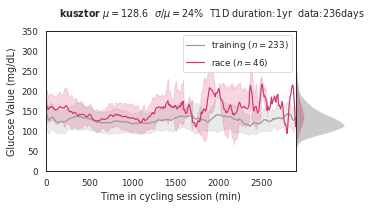

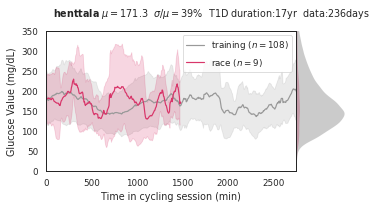

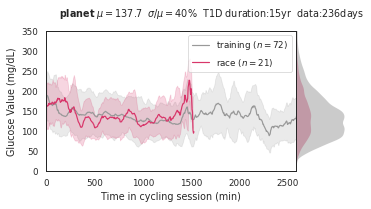

In [77]:
for i in dc[dc['race']].RIDER.unique():
	n_nc = len(dc.loc[(dc.RIDER == i) & (dc['race'] == False), 'local_timestamp'].dt.date.unique())
	n_rc = len(dc.loc[(dc.RIDER == i) & (dc['race'] == True), 'local_timestamp'].dt.date.unique())

	t_max = dc[dc.RIDER == i].groupby('tid')['t'].max().quantile(0.9)#dc.loc[dc.RIDER == i, 't'].max()

	fig, ax = plt.subplots(1,2, figsize=(5, 3), sharey=True, gridspec_kw={'width_ratios': [5, 1], 'wspace':0}, tight_layout=True)
	sns.lineplot(x=dc.loc[dc.RIDER == i,'t'], y=dc.loc[dc.RIDER == i, COL], ci='sd', hue=dc['race'], palette=list(color_race.values()), ax=ax[0])
	ax[0].set_xlabel('Time in cycling session (min)')
	ax[0].legend(loc='upper right', handles=ax[0].get_legend().get_lines(),
		labels=['training'+r' ($n = {:.0f}$)'.format(n_nc), 'race'r' ($n = {:.0f}$)'.format(n_rc)])
	sns.kdeplot(data=dc.loc[dc['t'].notna() & (dc.RIDER == i)], y=COL, hue='race', ax=ax[1],
		fill=True, alpha=.5, palette=list(color_race.values()), linewidth=0, legend=False)
	sns.despine(bottom=True, right=True, top=True, ax=ax[1])
	ax[1].set(xlabel=None, xticks=[])
	plt.ylim((0,350))
	ax[0].set_xlim((0, t_max))
	title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(dc[dc.RIDER == i][COL].mean(),
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				len(dc_agg.loc[i]))
	savefig(path='time_cycling/glucose_cycling', i=i, title=title, x=-1.7, y=1.06)

### Glucose during day

In [217]:
dc['time'] = timestamp_to_seconds(dc['local_timestamp'])

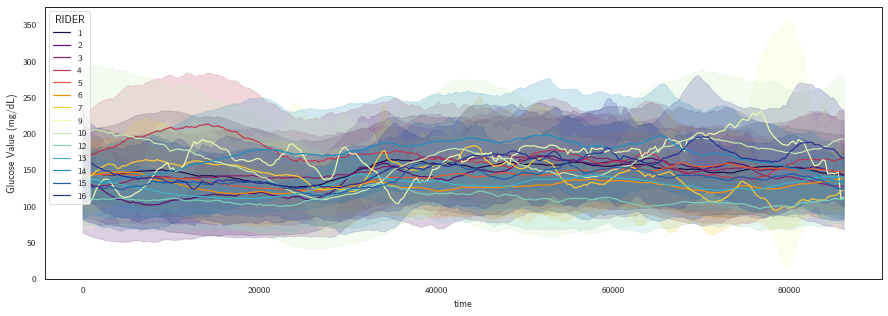

In [218]:
plt.figure(figsize=(15,5))
sns.lineplot(data=dc, x='time', y=COL, ci='sd', hue='RIDER', palette=palette_ath)
plt.ylim((0,375))
plt.show()

### Days with hypo events (during sections)

In [219]:
dc_agg = dc_agg.set_index(['RIDER', 'date'])

In [244]:
dc_agg

time_in_hypo_exercise  time_in_hypoL2_exercise  \
RIDER date                                                         
1     2018-11-05                   10.0                      4.0   
      2018-11-06                    1.0                      0.0   
      2018-11-07                   27.0                     10.0   
      2018-11-08                   10.0                      1.0   
      2018-11-09                    3.0                      0.0   
...                                 ...                      ...   
16    2019-01-22                    0.0                      0.0   
      2019-01-23                    0.0                      0.0   
      2019-01-24                    0.0                      0.0   
      2019-01-25                    6.0                      2.0   
      2019-01-26                    0.0                      0.0   

                  time_in_hypoL1_exercise  time_in_target_exercise  \
RIDER date                                                           
1     2018-11-05                      6.0                      2.0   
      2018-11-06                      1.0                     19.0   
      2018-11-07                     17.0                     25.0   
      2018-11-08                      9.0                     16.0   
      2018-11-09                      3.0                     32.0   
...                                   ...                      ...   
16    2019-01-22                      0.0                     12.0   
      2019-01-23                      0.0                     44.0   
      2019-01-24                      0.0                     38.0   
      2019-01-25                      4.0                     29.0   
      2019-01-26                      0.0                     28.0   

                  time_in_hyper_exercise  time_in_hyperL1_exercise  \
RIDER date                                                           
1     2018-11-05                     0.0                       0.0   
      2018-11-06                     0.0                       0.0   
      2018-11-07                     5.0                       5.0   
      2018-11-08                     0.0                       0.0   
      2018-11-09                     5.0                       5.0   
...                                  ...                       ...   
16    2019-01-22                    48.0                      35.0   
      2019-01-23                     3.0                       3.0   
      2019-01-24                    11.0                      11.0   
      2019-01-25                     1.0                       1.0   
      2019-01-26                    23.0                      17.0   

                  time_in_hyperL2_exercise  glucose_mean_exercise  \
RIDER date                                                          
1     2018-11-05                       0.0              59.500000   
      2018-11-06                       0.0             128.550000   
      2018-11-07                       0.0              85.333333   
      2018-11-08                       0.0              73.115385   
      2018-11-09                       0.0             110.375000   
...                                    ...                    ...   
16    2019-01-22                      13.0             213.166667   
      2019-01-23                       0.0             117.276596   
      2019-01-24                       0.0             149.040816   
      2019-01-25                       0.0             111.481481   
      2019-01-26                       6.0             178.941176   

                  glucose_std_exercise  glucose_cv_exercise  ...  \
RIDER date                                                   ...   
1     2018-11-05             13.283619             0.223254  ...   
      2018-11-06             24.079856             0.187319  ...   
      2018-11-07             45.414886             0.532206  ...   
      2018-11-08             12.127083             0.165862  ...   
     

In [288]:
dc_hypo = {}
for sec in SECTIONS+('1d',):
    dc_hypo[sec] = dc_agg['hypo_'+sec].groupby('RIDER').apply(lambda x: x.sum()/len(x))
dc_hypo = pd.concat(dc_hypo, axis=1) * 100
dc_hypo = dc_hypo.rename(columns={'1d':'total'})

In [289]:
dc_hyper = {}
for sec in SECTIONS+('1d',):
    dc_hyper[sec] = dc_agg['hyper_'+sec].groupby('RIDER').apply(lambda x: x.sum()/len(x))
dc_hyper = pd.concat(dc_hyper, axis=1) * 100
dc_hyper = dc_hyper.rename(columns={'1d':'total'})

Text(0.5, 1.0, 'Days in hyperglycemia')

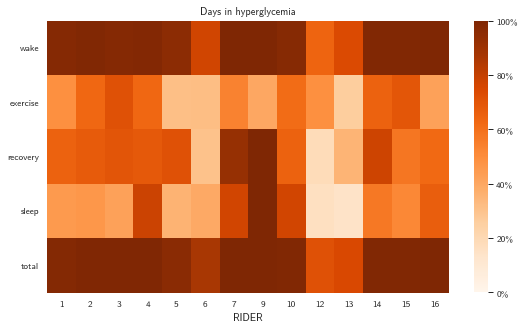

In [292]:
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(dc_hyper.T, vmin=0, vmax=100, cmap='Oranges')
fig.get_axes()[1].set_yticks(np.arange(0,101,20), ["{:.0f}%".format(j) for j in np.arange(0,101,20)])
plt.yticks(rotation=0)
plt.title("Days in hyperglycemia")

Text(0.5, 1.0, 'Days in hypoglycemia')

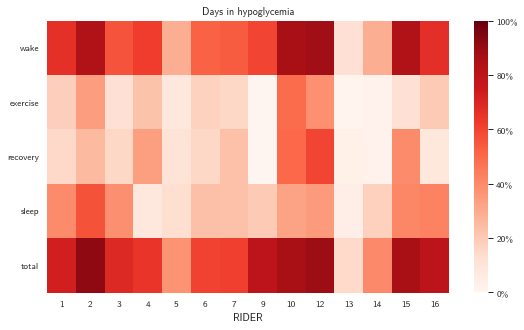

In [291]:
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(dc_hypo.T, vmin=0, vmax=100, cmap='Reds')
fig.get_axes()[1].set_yticks(np.arange(0,101,20), ["{:.0f}%".format(j) for j in np.arange(0,101,20)])

plt.yticks(rotation=0)
plt.title("Days in hypoglycemia")

In [220]:
dc_events = {}
for sec in SECTIONS+('1d',):
    dc_events[sec] = dc_agg[['time_in_hypo_'+sec, 'time_in_hyper_'+sec]].div(dc_agg['count_'+sec], axis=0)
    dc_events[sec].columns = ['_'.join(col.split('_')[:-1]) for col in dc_events[sec].columns]
    dc_events[sec] *= 100
    dc_events[sec] = dc_events[sec].sort_index(level=1)
    mask = (dc_events[sec]['time_in_hypo'] != 0) & (dc_events[sec]['time_in_hyper'] != 0)
    dc_events[sec].loc[mask, 'time_in_both'] = dc_events[sec]['time_in_hypo'] + dc_events[sec]['time_in_hyper']
    dc_events[sec].loc[mask, ['time_in_hypo', 'time_in_hyper']] = 0
    dc_events[sec] = dc_events[sec].replace({0:np.nan})

In [243]:
dc_events['wake']

time_in_hypo  time_in_hyper  time_in_both
RIDER date                                                 
1     2018-11-05           NaN            NaN     30.569948
      2018-11-06           NaN            NaN     17.961165
      2018-11-07           NaN            NaN     40.211640
      2018-11-08           NaN            NaN     20.370370
      2018-11-09           NaN            NaN     35.784314
...                        ...            ...           ...
12    2019-11-01           NaN            NaN     21.759259
      2019-11-02           NaN            NaN     11.574074
      2019-11-03           NaN            NaN     13.888889
      2019-11-04           NaN            NaN     15.740741
      2019-11-05           NaN            NaN     10.563380

[2120 rows x 3 columns]

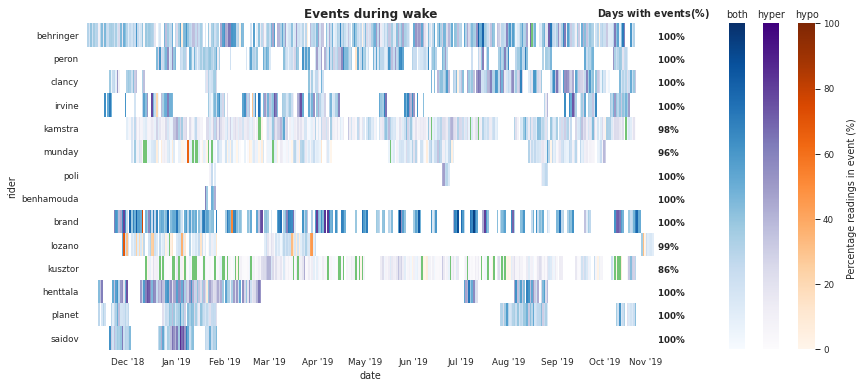

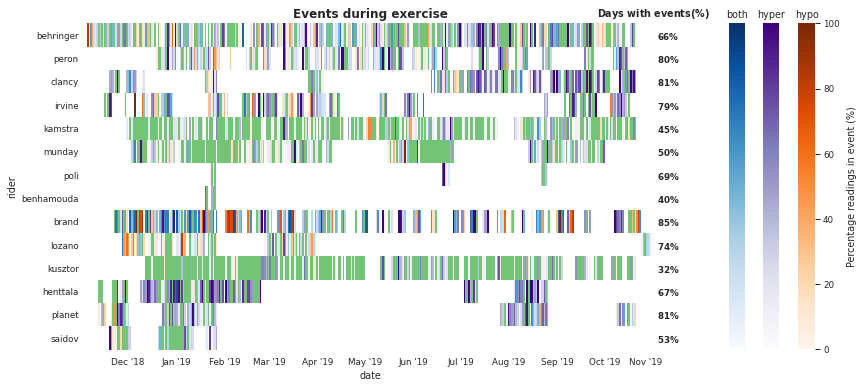

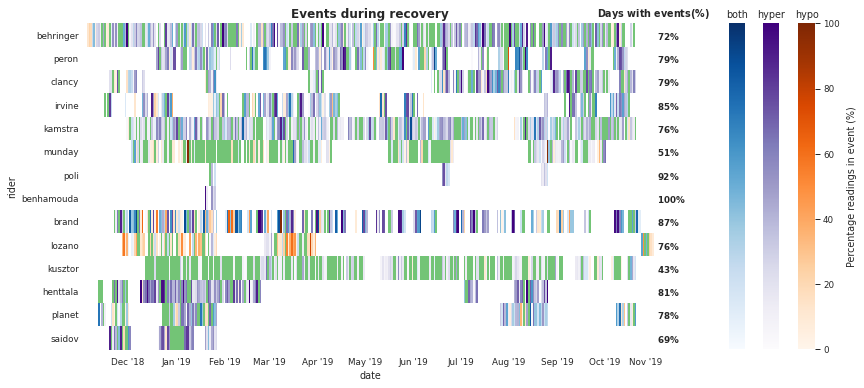

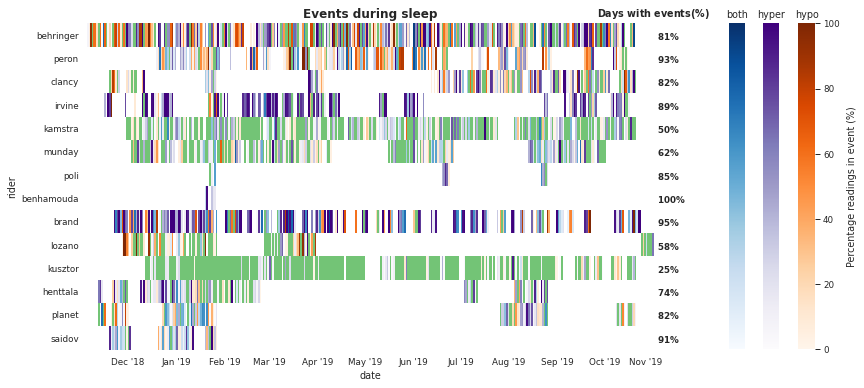

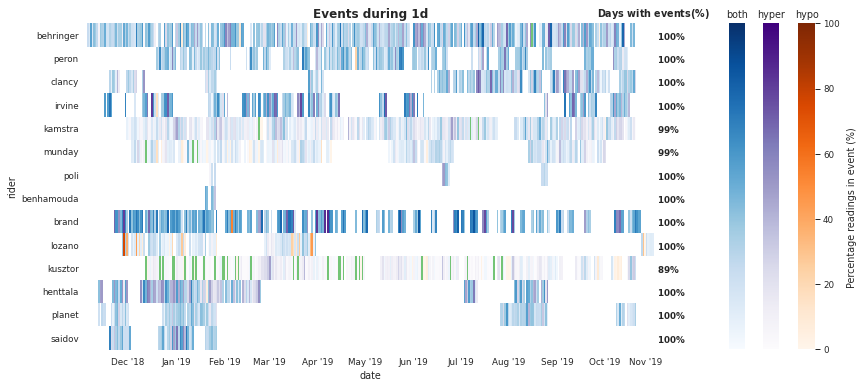

In [93]:
EVENTS = {'hypo': {'cmap':'Oranges', 'cbar_kws':{'pad':-0.1}},
          'hyper':{'cmap':'Purples', 'cbar_kws':{'pad':-0.1}}, 
          'both': {'cmap':'Blues'  , 'cbar_kws':{'pad':0.1}}}
for sec in SECTIONS+('1d',):
    fig, ax = plt.subplots(figsize=(15,6))
    
    df_avail = dc_events[sec].isna().all(axis=1).astype(float).unstack()
    sns.heatmap(df_avail, ax=ax, vmin=0, vmax=2, cmap='Greens', cbar=False)
    for event, kwargs in EVENTS.items():
        df_avail = dc_events[sec]['time_in_'+event].unstack()
        sns.heatmap(df_avail, ax=ax, vmin=0, vmax=100, **kwargs)
    
    # percentage columns
    perc_events = dc_events[sec].unstack().count(axis=1)/\
        dc_events[sec].reset_index().groupby('RIDER')['date'].count()*100
    ax2 = ax.secondary_yaxis("right")
    ax2.set_yticks(np.arange(len(df_avail.index))+0.5)
    ax2.set_yticklabels([r"$\bf{:.0f}\%$".format(i) for i in perc_events])
    ax2.tick_params(axis='y', length=0)
    ax2.spines['right'].set_visible(False)
    ax.text(0.9, 1.02, r'$\bf{:s}$'.format('Days\ with\ events (\%)'), ha='left', transform=ax.transAxes) 
    
    # colorbar
    for j, cbar_ax in enumerate(fig.get_axes()[1:]):
        if j != 0:
            cbar_ax.set_yticks([]) ; cbar_ax.set_yticklabels([])
        cbar_ax.set_title(list(EVENTS.keys())[j])
        if j == 0:
            cbar_ax.text(3, dc_events[sec].max().max()/2, 'Percentage readings in event (%)', va='center', rotation=90)
            
    monthyear = df_avail.columns.strftime("%b '%y")
    ticksloc = np.where(monthyear.to_series().shift() != monthyear.to_series())[0][1:]
    plt.xticks(ticks=ticksloc, labels=monthyear[ticksloc], rotation=0)
    plt.xlabel('date')
    plt.ylabel('rider')
    plt.title('Events during '+sec, fontweight='bold', fontsize=12)
    savefig('events/events', i=sec, yticks=ax)

### Stats

**TODO**: Do we normalize these statistics by the amount of data that we have per person?

**Stats for patient population**

In [221]:
# ------ info
cols_info = {'age'    : 'Age (yr)',
             'gender' : 'Sex (male/female)',
             'height' : 'Height (cm)',
             'weight' : 'Weight (kg)',
             'bf(%)'  : 'Fat mass (\%)'}

info['FTP_per_kg'] = info['FTP'] / info['weight']
info = info.drop('FTP', axis=1)

stats_info = info.loc[:,info.columns.isin(cols_info.keys())]
stats_info = stats_info.rename(columns=cols_info)

In [222]:
# ------ diabetes
cols_diab = {'diabetes_duration' : 'Diabetes duration (yr)',
             'HbA1c'             : 'HbA_{1c} (\%)',
             'cgm_days'          : 'Days with CGM coverage $\geq$ 70 \%'}

stats_diab = info.loc[:, info.columns.isin(cols_diab.keys())]
stats_diab['cgm_days'] = dc_agg.reset_index().groupby('RIDER')['date'].count()
stats_diab = stats_diab.rename(columns=cols_diab)

/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [223]:
# ------ exercise
cols_ex = {'FTP_per_kg'                : 'Functional threshold power (W/kg)',
           'LTHR'                      : 'Lactate threshold heart rate (bpm)',
           'HRmax'                     : 'HR_{max} (bpm)',
           'VO2max'                    : 'VO_{2max} (mL/min/kg)',
           'days_per_year_cycled'      : 'Cycling (days/yr)',
           'days_per_year_raced'       : 'Competition (days/yr)',
           'km_per_year_cycled'        : 'Distance cycled (km/yr)',
           'mean_hours_per_day_cycled' : 'Mean time cycled (h/day)',
           'mean_km_per_day_cycled'    : 'Mean distance cycled (km/day)',
           'mean_km_per_day_ascended'  : 'Mean ascension (km/day)'}

tp_agg0 = tp_agg.set_index(['RIDER', 'date'])
tp_agg0.columns = tp_agg0.columns.get_level_values(1)
tp_agg0 = tp_agg0.reset_index()

stats_ex_yr = tp_agg0.groupby('RIDER').agg({'date'        :'count', 
                                            'race'        :'sum', 
                                            'distance_max':lambda x: x.sum()/1000})\
                           .rename(columns={'date'        :'days_per_year_cycled',
                                            'race'        :'days_per_year_raced',
                                            'distance_max':'km_per_year_cycled'})

stats_ex_day = tp_agg0.groupby('RIDER')[['timestamp_count', 'distance_max', 'elevation_gain_up_sum']]\
    .agg(lambda x: x.mean()/3600)\
    .rename(columns={'timestamp_count'      :'mean_hours_per_day_cycled',
                     'distance_max'         :'mean_km_per_day_cycled',
                     'elevation_gain_up_sum':'mean_km_per_day_ascended'})

stats_ex = info[sorted(set(cols_ex.keys()) & set(info.columns))]
stats_ex = pd.merge(stats_ex, stats_ex_yr, left_index=True, right_index=True, how='outer')
stats_ex = pd.merge(stats_ex, stats_ex_day, left_index=True, right_index=True, how='outer')
stats_ex = stats_ex.rename(columns=cols_ex)

In [224]:
stats = pd.concat([stats_info, stats_diab, stats_ex], axis=1)
stats

Sex (male/female)  Age (yr)  Weight (kg)  Fat mass (\%)  Height (cm)  \
RIDER                                                                        
1                     M        22    60.500000       9.066667        174.0   
2                     M        30    71.633333       8.833333        178.0   
3                     M        26    66.733333       6.566667        171.0   
4                     M        19    78.666667       9.433333        178.0   
5                     M        25    69.633333       7.700000        183.0   
6                     M        20    56.700000       4.950000        169.0   
7                     M        22    65.333333       8.066667        167.0   
9                     M        23    63.100000       8.533333        173.0   
10                    M        27    75.466667       7.700000        185.0   
12                    M        30    64.000000       5.600000        178.0   
13                    M        34    60.333333       4.866667        179.0   
14                    M        27    75.166667       9.333333        187.0   
15                    M        25    73.766667       7.200000        179.0   
16                    M        22    56.666667       9.466667        170.0   

       Diabetes duration (yr)  HbA_{1c} (\%)  \
RIDER                                          
1                          11            6.7   
2                          14            6.6   
3                           7            6.8   
4                           7            7.8   
5                           6            6.5   
6                           9            6.4   
7                           6            5.9   
9                          10            7.2   
10                         17            7.3   
12                          8            6.0   
13                          1            6.3   
14                         17            7.1   
15                         15            6.4   
16                         13            6.6   

       Days with CGM coverage $\geq$ 70 \%  Functional threshold power (W/kg)  \
RIDER                                                                           
1                                      318                           5.074380   
2                                      179                           4.550954   
3                                      141                           4.465534   
4                                      130                           4.525424   
5                                      298                           4.897080   
6                                      207                           5.264550   
7                                       13                           4.568878   
9                                        5                           4.416270   
10                                     203                           5.000000   
12                                      92                           5.421875   
13                                     279                           5.729282   
14                                     117                           4.629712   
15                                      93                           5.273385   
16                                      45                           5.000000   

       HR_{max} (bpm)  Lactate threshold heart rate (bpm)  \
RIDER                                                       
1          192.333333                          176.333333   
2          181.666667                          168.666667   
3          180.000000                          171.000000   
4          187.333333                          170.333333   
5          192.666667                          179.666667   
6          184.500000                          173.000000   
7          180.500000                          171.500000   
9          195.000000                          182.333333   
10         194.333333                          177.000000   
12         178.66666

Calculate mean and std over all riders and write to latex

In [226]:
def agg_gender(x):
    count = x.value_counts()
    male = count['M'] if 'M' in count else 0
    female = count['F'] if 'F' in count else 0
    return f'{male}/{female}'

In [235]:
stats_agg = pd.concat([stats.mean(), stats.std(), stats.min(), stats.max()], axis=1)
stats_agg = stats_agg.replace({'M':np.nan}).round(1).apply(lambda x: f'{x[0]} $\pm$ {x[1]} & ({x[2]} - {x[3]})', axis=1)
stats_agg = pd.concat([pd.Series(stats['Sex (male/female)'].agg(agg_gender), index=['Sex (male/female)']),
                       stats_agg])

with open(SAVE_PATH+"stats.tex", 'w') as file:
	file.write(stats_agg.to_latex(column_format='c', escape=False))

**Stats for CGM**

In [236]:
cols_cgm = {'glucose_mean'    : 'Mean glucose (mg/dL)',
            'glucose_cv'      : 'Glycemic variability (\%)',
            'time_in_hypoL2'  : 'hypoglycemia L2 (<54 mg/dL)',
            'time_in_hypoL1'  : 'hypoglycemia L1 (54-69 mg/dL)',
            'time_in_target'  : 'target range (70-180 mg/dL)',
            'time_in_hyperL1' : 'hyperglycemia L1 (181-250 mg/dL)',
            'time_in_hyperL2' : 'hyperglycemia L2 (>250 mg/dL)'}

In [237]:
# TODO: check if still in line with new value of glucose_levels
# calculate dysglycemia events
dc['hypo'] = dc.groupby('RIDER')[COL].transform(lambda x: (x <= glucose_levels['hypo L1'][1]) \
														& (x.shift(1) <= glucose_levels['hypo L1'][1]) \
														& (x.shift(2) <= glucose_levels['hypo L1'][1]))
dc['hyper'] = dc.groupby('RIDER')[COL].transform(lambda x: (x >= glucose_levels['hyper L1'][0]) \
														 & (x.shift(1) >= glucose_levels['hyper L1'][0]) \
														 & (x.shift(2) >= glucose_levels['hyper L1'][0]))

# glucose rate
dc['glucose_rate'] = dc[COL] / (dc['timestamp'].diff()/pd.to_timedelta('5min'))

In [238]:
stats_cgm = {'Total': dc.groupby('RIDER').apply(stat_func).apply(pd.Series)}
stats_cgm.update({sec: dc[dc[sec]].groupby('RIDER').apply(stat_func).apply(pd.Series) for sec in SECTIONS})

In [239]:
stats_cgm

{'Total':        time_in_hypo_  time_in_hypoL2_  time_in_hypoL1_  time_in_target_  \
 RIDER                                                                     
 1               7229             1190             6039            55688   
 2               5407             1581             3826            31824   
 3               2167              499             1668            25866   
 4               1547              529             1018            18269   
 5               1203              180             1023            67694   
 6               1786              357             1429            49297   
 7                181               23              158             2587   
 9                 23                2               21              747   
 10              8012             4495             3517            25296   
 12              3328              804             2523            20389   
 13               319               11              308            73204   
 14

In [240]:
for k, df in stats_cgm.items():
    df.columns = df.columns.str.rstrip('_')
    cols_time = df.columns.str.startswith('time_in')
    df.loc[:, cols_time] = df.loc[:, cols_time].div(df['count'], axis=0) * 100 # calculate perc
    df['glucose_cv'] *= 100
    df = df[['glucose_mean', 'glucose_cv', 'time_in_hypoL2', 'time_in_hypoL1',
       'time_in_target', 'time_in_hyperL1', 'time_in_hyperL2']]
    stats_cgm[k] = df
stats_cgm = pd.concat(stats_cgm, axis=1)
stats_cgm

Total                                                          \
      glucose_mean glucose_cv time_in_hypoL2 time_in_hypoL1 time_in_target   
RIDER                                                                        
1       148.976550  44.125540       1.370952       6.957293      64.155943   
2       140.461023  49.883867       3.260937       7.891426      65.639503   
3       149.113634  39.744621       1.288473       4.306961      66.788887   
4       170.042101  40.816345       1.561255       3.004457      53.917894   
5       142.000734  28.649001       0.221024       1.256155      83.122337   
6       128.486328  31.075262       0.628997       2.517751      86.856247   
7       142.017568  37.296337       0.641383       4.406023      72.141662   
9       166.166283  29.191378       0.153610       1.612903      57.373272   
10      162.844550  54.332909       8.415869       6.584786      47.361030   
12      109.211025  35.142551       3.230213      10.136601      81.916432   
13      128.637051  24.066677       0.014014       0.392392      93.261820   
14      171.305643  38.763126       0.242599       1.240634      61.902715   
15      137.720938  39.930203       2.537814       5.656479      71.592858   
16      155.577255  40.811621       0.714114       3.739068      62.312445   

                                              wake                            \
      time_in_hyperL1 time_in_hyperL2 glucose_mean glucose_cv time_in_hypoL2   
RIDER                                                                          
1           19.170286        8.344374   151.143631  40.723140       0.667296   
2           14.450426        8.530825   149.066942  47.763792       1.837256   
3           21.483165        6.132514   153.051252  38.110856       0.856575   
4           28.323938       13.074403   161.558315  41.298221       1.687382   
5           13.737890        1.553310   143.849933  28.865817       0.190209   
6            9.110770        0.877425   127.495432  29.517164       0.546307   
7           20.161740        2.593419   137.341269  39.146853       0.300413   
9           37.711214        3.149002   170.709267  29.026835       0.203666   
10          20.342252       17.253000   158.793696  55.411670       8.583407   
12           4.314986        0.377662   109.884411  34.842666       3.133888   
13           6.140675        0.188552   131.660177  23.875496       0.018756   
14          23.977398       12.473898   177.442408  37.116595       0.176345   
15          16.466552        3.656635   140.175634  39.926166       1.932591   
16          25.242718        7.991655   161.255174  40.229207       0.489935   

       ...       recovery                                        sleep  \
       ... time_in_target time_in_hyperL1 time_in_hyperL2 glucose_mean   
RIDER  ...                                                               
1      ...      68.624631       22.625085        6.706532   142.675018   
2      ...      64.508816       18.526448       12.544081   113.371777   
3      ...      65.592204       24.827586        7.286357   137.069692   
4      ...      59.318441       25.044839       10.321213   195.540596   
5      ...      70.856912       23.371059        3.936944   136.088006   
6      ...      87.855470        7.694881        0.769488   131.431071   
7      ...      72.673031       16.706444        7.279236   155.509426   
9      ...      48.132780       51.867220        0.000000   152.225000   
10     ...      53.578378       19.989189       16.302703   175.933851   
12     ...      80.656780        2.817797        0.211864   107.204860   
13     ...      90.793974        8.494316        0.268047   119.702797   
14     ...      50.908711       29.183205       19.511176   153.012384   
15     ...      67.341115       20.933852        5.239948   130.097551   
16     ...      54.084864       33.502217       10.766308   138.235036   

                                                                  

In [241]:
stats_cgm = pd.concat([stats_cgm.mean(), stats_cgm.std()], axis=1)
stats_cgm = stats_cgm.round(1).apply(lambda x: '%s $\pm$ %s'%(x[0], x[1]), axis=1)
stats_cgm = stats_cgm.unstack().T
stats_cgm = stats_cgm.rename(index=cols_cgm)
stats_cgm = stats_cgm[['Total', 'wake', 'sleep', 'exercise', 'recovery']]

with open(SAVE_PATH+"stats_cgm.tex", 'w') as file:
	file.write(stats_cgm.to_latex(column_format='c', escape=False))

stats_cgm

Total              wake  \
Mean glucose (mg/dL)              146.6 $\pm$ 17.8  148.1 $\pm$ 18.0   
Glycemic variability (\%)           38.1 $\pm$ 8.2    37.6 $\pm$ 8.2   
hypoglycemia L2 (<54 mg/dL)          1.7 $\pm$ 2.2     1.5 $\pm$ 2.2   
hypoglycemia L1 (54-69 mg/dL)        4.3 $\pm$ 2.9     3.7 $\pm$ 2.7   
target range (70-180 mg/dL)        69.2 $\pm$ 13.2   69.3 $\pm$ 13.2   
hyperglycemia L1 (181-250 mg/dL)    18.6 $\pm$ 9.0    19.2 $\pm$ 9.6   
hyperglycemia L2 (>250 mg/dL)        6.2 $\pm$ 5.3     6.3 $\pm$ 5.1   

                                             sleep          exercise  \
Mean glucose (mg/dL)              142.0 $\pm$ 23.7  146.2 $\pm$ 18.8   
Glycemic variability (\%)           38.4 $\pm$ 9.4   39.0 $\pm$ 10.0   
hypoglycemia L2 (<54 mg/dL)          2.5 $\pm$ 2.6     1.3 $\pm$ 2.7   
hypoglycemia L1 (54-69 mg/dL)        5.9 $\pm$ 4.5     3.6 $\pm$ 3.3   
target range (70-180 mg/dL)        68.8 $\pm$ 16.1   70.8 $\pm$ 13.9   
hyperglycemia L1 (181-250 mg/dL)   16.9 $\pm$ 10.0    17.6 $\pm$ 9.3   
hyperglycemia L2 (>250 mg/dL)        5.8 $\pm$ 7.5     6.7 $\pm$ 5.5   

                                          recovery  
Mean glucose (mg/dL)              154.6 $\pm$ 22.2  
Glycemic variability (\%)           35.9 $\pm$ 8.8  
hypoglycemia L2 (<54 mg/dL)          1.1 $\pm$ 1.5  
hypoglycemia L1 (54-69 mg/dL)        3.0 $\pm$ 3.0  
target range (70-180 mg/dL)        66.8 $\pm$ 13.2  
hyperglycemia L1 (181-250 mg/dL)   21.8 $\pm$ 12.1  
hyperglycemia L2 (>250 mg/dL)        7.2 $\pm$ 6.1

## Descriptives TrainingPeaks

Prepare time features

In [136]:
# TODO: count is not exactly duration (because we only count when there's a measurement)

# prepare time features
tp_agg[('TIME', 'time_start')] = timestamp_to_seconds(tp_agg[('TIME', 'local_timestamp_min')])
tp_agg[('TIME', 'time_end')] = timestamp_to_seconds(tp_agg[('TIME', 'local_timestamp_max')])
tp_agg = tp_agg.drop([('TIME', 'local_timestamp_min'),
                      ('TIME', 'local_timestamp_max')], axis=1)
tp_agg = tp_agg.rename(columns={'timestamp_count':'duration'})

# get day in season
season_list['day_in_season'] = season_list.groupby('RIDER')['date'].transform(lambda x: x - x.min()).dt.days
season_list.columns = pd.MultiIndex.from_tuples([('RIDER', ''), ('date', ''), ('TIME', 'day_in_season')])
tp_agg = pd.merge(tp_agg, season_list, how='left', on=['RIDER', 'date'])

# calculate percentage in zones
cols_zones = [('POWER', 'time_in_power_zone%s'%n) for n in range(1,7)] + [('HR', 'time_in_hr_zone%s'%n) for n in range(1,6)]
tp_agg[[(mod, 'perc'+c.lstrip('time')) for (mod, c) in cols_zones]] = tp_agg[cols_zones].apply(lambda col: col.divide(tp_agg[('TIME', 'duration')]))
tp_agg = tp_agg.drop(cols_zones, axis=1)

# rename
tp_agg = tp_agg.rename(columns={'chronic_training_load'  :'fitness', 
                                'acute_training_load'    :'fatigue', 
                                'training_stress_balance':'form'})

cols_cat = [('CALENDAR', 'race'), ('CALENDAR', 'travel'),
            ('CALENDAR', 'travel_3d_any'), ('CALENDAR', 'travel_7d_any')]
tp_agg[cols_cat] = tp_agg[cols_cat].astype('category')

# replace np.inf
tp_agg = tp_agg.replace({np.inf:np.nan})

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Replace extreme values

In [137]:
from scipy.stats import zscore

def clip_extremes(df, z_max=4, **kwargs):
    """
    Clip extreme values: when values exceed z_max, replace with mu+-z_max*std
    """
    z = zscore(df, **kwargs)
    mu = df.mean() 
    sigma = df.std()
    df = df.mask(z > z_max, mu + z_max*sigma)
    df = df.mask(z < -z_max, mu - z_max*sigma)
    return df
    
# note: we do not winsorize as that is based on percentiles, rather clip based on std
cols_extreme = tp_agg.set_index(['RIDER', 'date']).columns.drop(cols_cat).drop([('CALENDAR', 'race_3d_mean'), 
                                                                                ('CALENDAR', 'race_7d_mean')])
z = np.abs(zscore(tp_agg[cols_extreme], nan_policy='omit'))
print("Percentage of extreme values in data: {:.2f}%".format(
    (z > 4).sum().sum() / tp_agg[cols_extreme].count().sum() * 100))
for col in cols_extreme:
    tp_agg[col] = clip_extremes(tp_agg[col], nan_policy='omit')

Percentage of extreme values in data: 0.45%


Plot distributions

In [138]:
cols_select = [ ('TIME', 'duration'),
                ('TIME', 'time_start'),
                ('TIME', 'time_end'),#remove
                ('TIME', 'day_in_season'),

                ('CALENDAR', 'travel_7d_any'),#remove
                ('CALENDAR', 'travel_3d_any'),
                ('CALENDAR', 'travel'),#remove
                ('CALENDAR', 'race'),
                ('CALENDAR', 'country_carbs'),

                ('HR', 'perc_in_hr_zone1'),
                ('HR', 'perc_in_hr_zone2'),
                ('HR', 'perc_in_hr_zone3'),
                ('HR', 'perc_in_hr_zone4'),
                ('HR', 'perc_in_hr_zone5'),

                ('POWER', 'training_stress_score'),
                ('POWER', 'fitness'),
                ('POWER', 'fatigue'),
                ('POWER', 'form'), # remove because = fitness - fatigue
                ('POWER', 'variability_index'),
                ('POWER', 'efficiency_factor'),
                ('POWER', 'perc_in_power_zone1'),
                ('POWER', 'perc_in_power_zone2'),
                ('POWER', 'perc_in_power_zone3'),
                ('POWER', 'perc_in_power_zone4'),
                ('POWER', 'perc_in_power_zone5'),
                ('POWER', 'perc_in_power_zone6'),

                ('LOC', 'temperature_min'),
                ('LOC', 'temperature_max'),
                ('LOC', 'altitude_mean'),
                ('LOC', 'elevation_gain_up_sum')] # TODO: check if we should remove

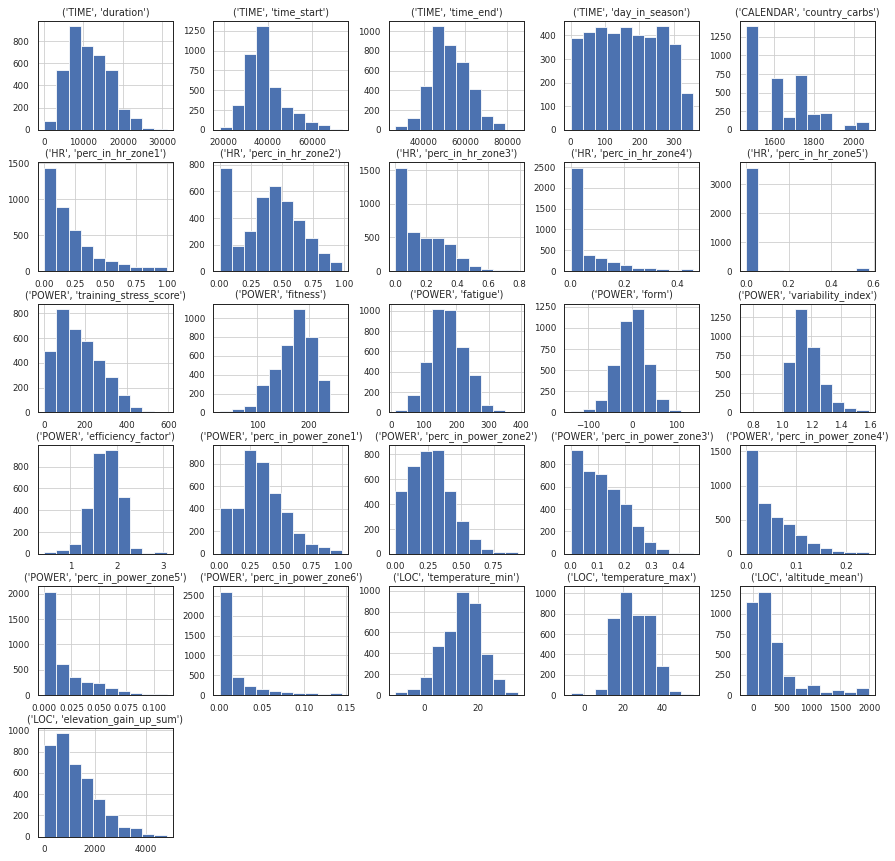

In [139]:
tp_agg[cols_select].hist(figsize=(15,15)) ; plt.show()

Plot correlations

In [140]:
corr = tp_agg[cols_select].corr()

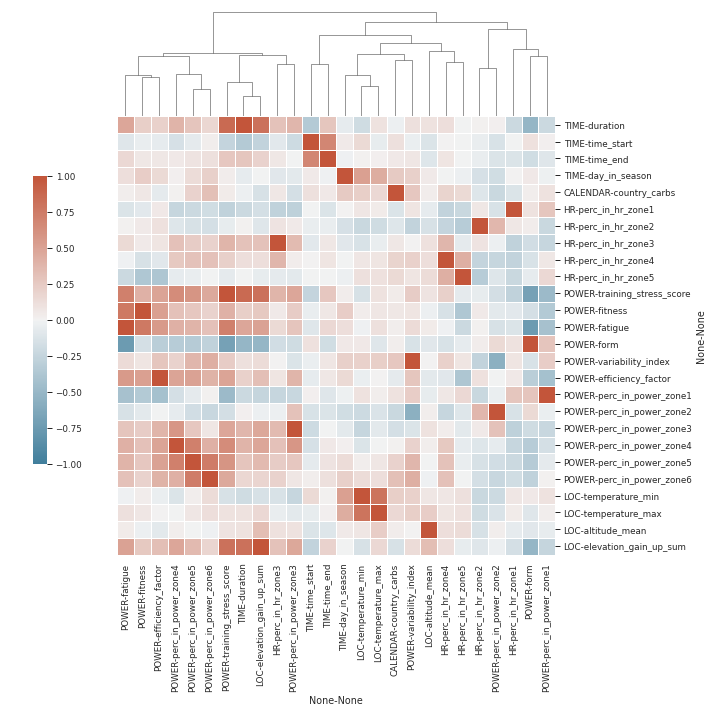

In [141]:
sns.clustermap(corr, vmin=-1, vmax=1, center=0, row_cluster=False, cbar_pos=(0.05, .35, .02, .4),
    linewidths=.5, cmap=sns.diverging_palette(230,20,as_cmap=True))
plt.xlabel('') ; plt.ylabel('') ; plt.show()

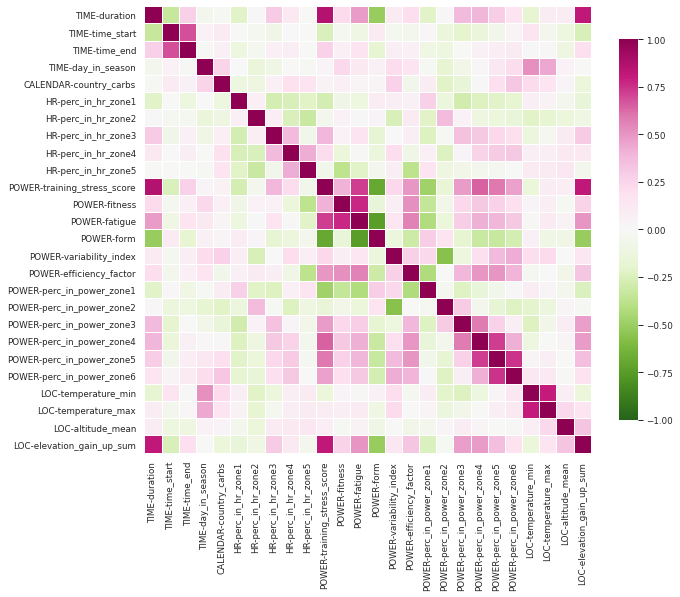

In [142]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap='PiYG_r',
            linewidths=.5, cbar_kws=dict(shrink=0.7), square=True)
plt.xlabel('') ; plt.ylabel('') ; plt.show()

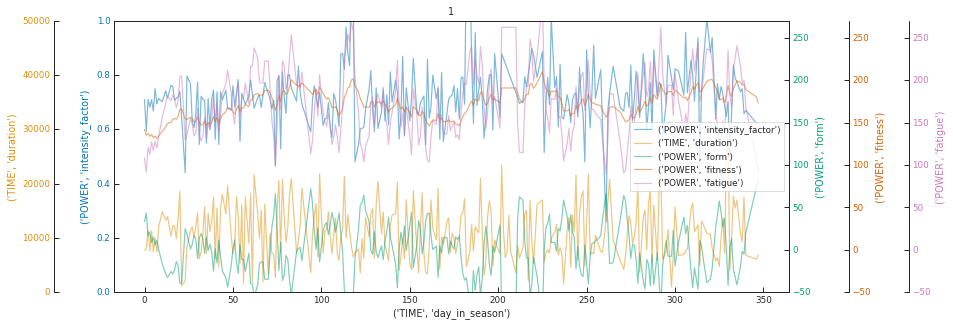

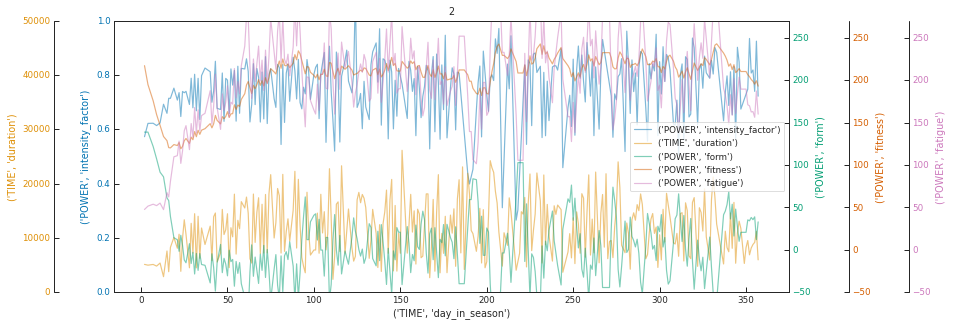

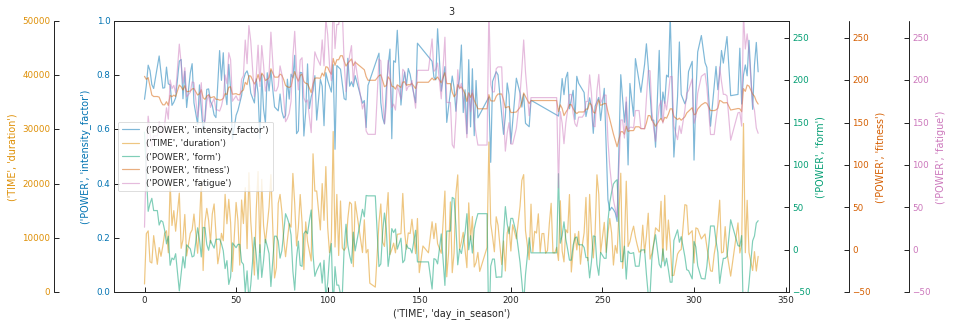

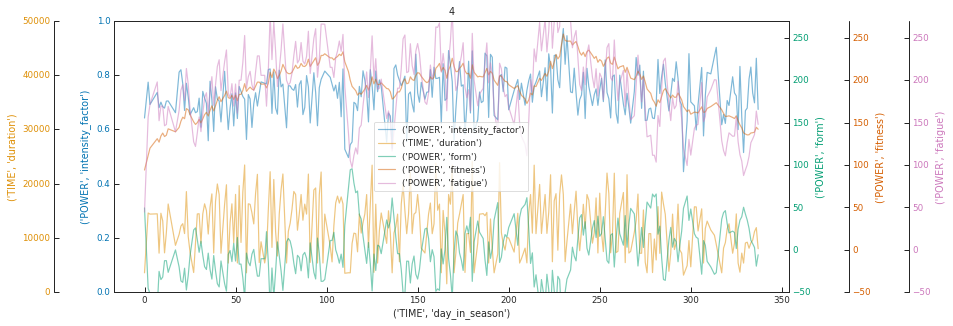

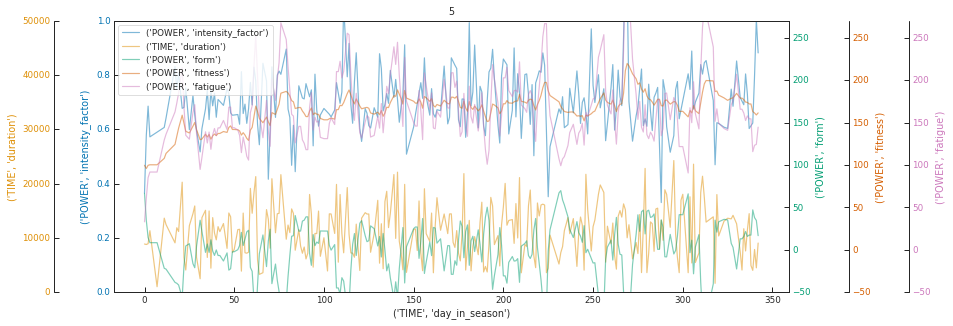

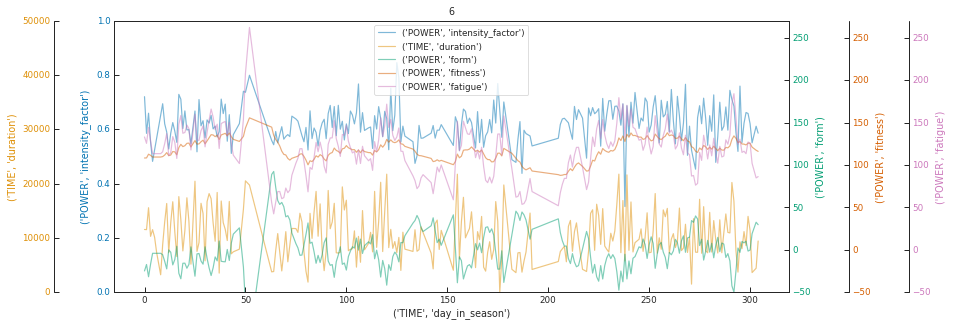

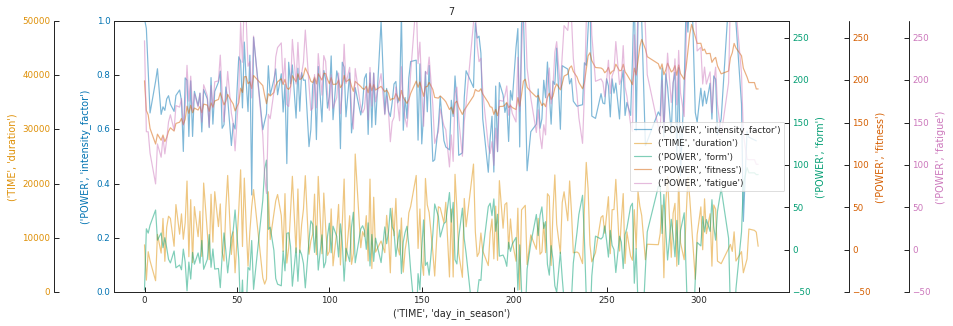

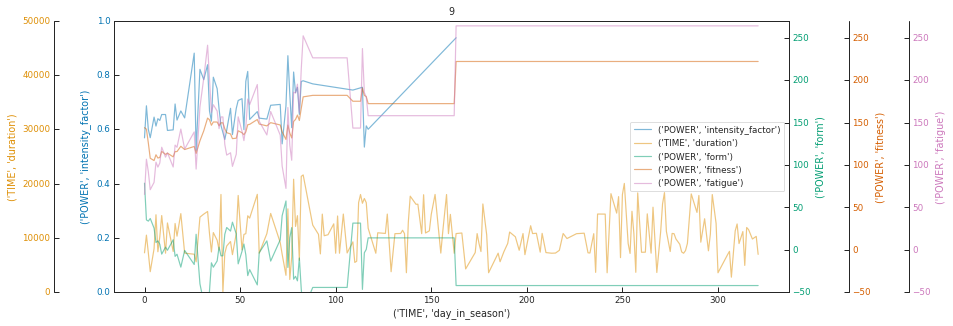

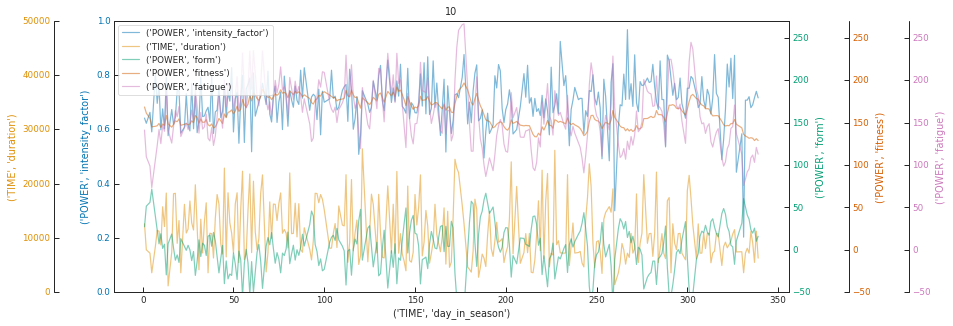

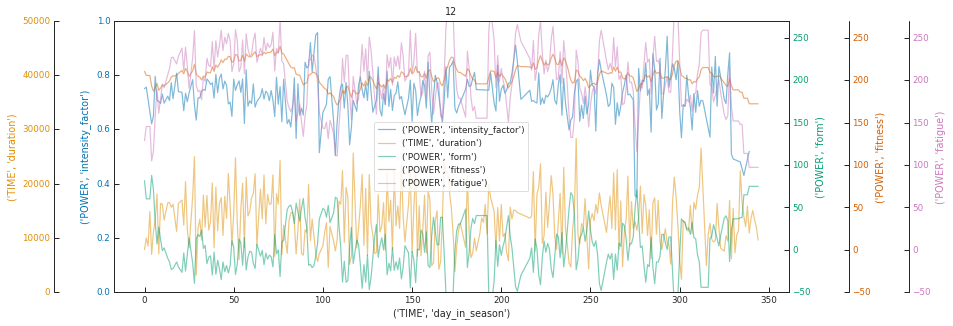

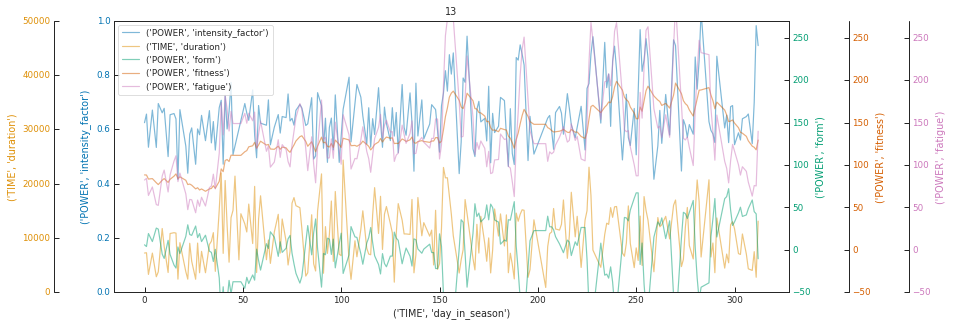

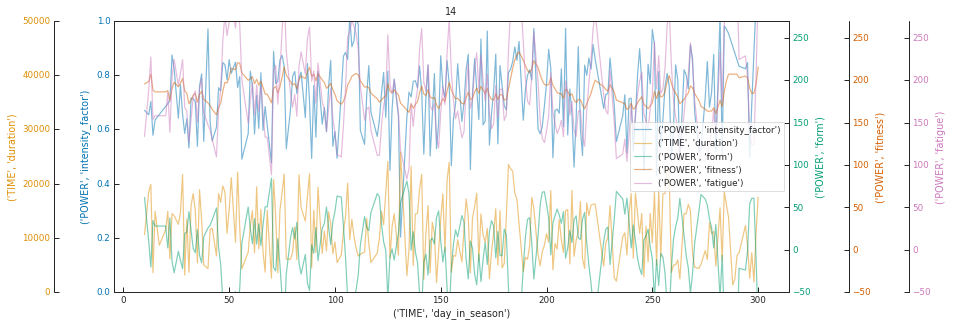

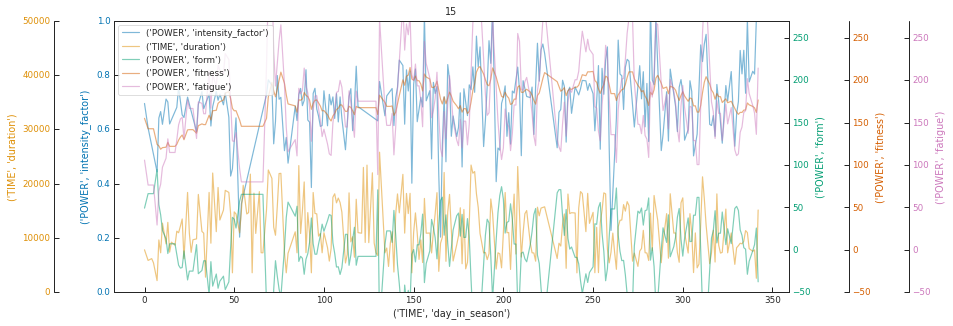

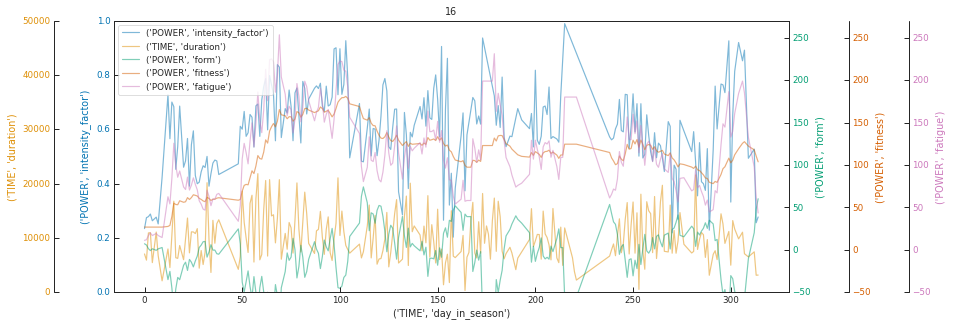

In [143]:
cols_plot = {('POWER', 'intensity_factor'): {'loc':'left', 'ylim':(0,1)},
             ('TIME', 'duration')         : {'loc':'left', 'ylim':(0,50000)},
             ('POWER', 'form')            : {'loc':'right', 'ylim':(-50,270)},
             ('POWER', 'fitness')         : {'loc':'right', 'ylim':(-50,270)},
             ('POWER', 'fatigue')         : {'loc':'right', 'ylim':(-50,270)}}

for i in ATHLETES:
    plt.figure(figsize=(15,5)) ; ax = []
    ax.append(host_subplot(111, axes_class=AA.Axes))
    plt.subplots_adjust(right=0.75)

    lr_count = {'left':0, 'right':0}
    for n, (col, kws) in enumerate(cols_plot.items()):
        ax.append(ax[0].twinx())
        offset = (lr_count[kws['loc']])*60
        if kws['loc'] == 'left':
            offset *= -1
        ax[n].axis['right'].toggle(all=False)
        ax[n].axis[kws['loc']] = ax[n].get_grid_helper().new_fixed_axis(loc=kws['loc'], axes=ax[n], offset=(offset, 0))
        lr_count[kws['loc']] += 1

    for n, (col, kws) in enumerate(cols_plot.items()):
        sns.lineplot(data=tp_agg[tp_agg.RIDER == i], x=('TIME', 'day_in_season'), y=col, ax=ax[n], 
                     label=col, color=sns.color_palette('colorblind')[n], alpha=.5)
        ax[n].axis[kws['loc']].label.set_color(ax[n].get_lines()[0].get_color())
        ax[n].axis[kws['loc']].major_ticklabels.set_color(ax[n].get_lines()[0].get_color())
        ax[n].set_ylim(kws['ylim'])
        ax[n].get_legend().remove()

    ax[-1].axis['right'].toggle(all=False)
    ax[0].axis['top'].toggle(all=False)

    ax[0].legend()
    
    plt.title(i)

    plt.show()

In [14]:
info = pd.read_csv(DATA_PATH+'./info.csv', index_col=0)
info.set_index('RIDER', inplace=True)
info

age  diabetes_duration  height     weight     bf(%)  HbA1c  \
RIDER                                                                
1      22.0               11.0   174.0  60.500000  9.066667    6.7   
2      30.0               14.0   178.0  71.633333  8.833333    6.6   
3      26.0                7.0   171.0  66.733333  6.566667    6.8   
4      19.0                7.0   178.0  78.666667  9.433333    7.8   
5      25.0                6.0   183.0  69.633333  7.700000    6.5   
6      20.0                9.0   169.0  56.700000  4.950000    6.4   
10     27.0               17.0   185.0  75.466667  7.700000    7.3   
12     30.0                8.0   178.0  64.000000  5.600000    6.0   
13     34.0                1.0   179.0  60.333333  4.866667    6.3   
14     27.0               17.0   187.0  75.166667  9.333333    7.1   
15     25.0               15.0   179.0  73.766667  7.200000    6.4   

              FTP        LTHR       HRmax     VO2max  
RIDER                                                 
1      307.000000  176.333333  192.333333  68.888889  
2      326.000000  168.666667  181.666667  66.915285  
3      298.000000  171.000000  180.000000  66.666164  
4      356.000000  170.333333  187.333333  67.333333  
5      341.000000  179.666667  192.666667  72.857143  
6      298.500000  173.000000  184.500000  70.781588  
10     377.333333  177.000000  194.333333  73.982571  
12     347.000000  158.333333  178.666667  75.937500  
13     345.666667  173.000000  182.333333  76.666667  
14     348.000000  169.000000  189.500000  66.500000  
15     389.000000  185.000000  198.000000  66.000000

In [27]:
percinlevel = {i:get_percinlevel(df[df.RIDER == i]) for i in ATHLETES}
percinlevel = pd.DataFrame(percinlevel).T
percinlevel['hypo'] = percinlevel['hypo L2'] + percinlevel['hypo L1']
percinlevel['hyper'] = percinlevel['hyper L1'] + percinlevel['hyper L2']
percinlevel

hypo L2   hypo L1     target   hyper L1   hyper L2       hypo      hyper
1   1.209455  6.730493  64.032547  19.491675   8.535830   7.939947  28.027506
2   3.319630  8.091153  66.078939  14.069814   8.224224  11.410783  22.294038
3   1.387432  4.821754  67.102023  20.653035   6.035756   6.209185  26.688791
4   1.772771  3.610159  57.773782  26.127999  10.715289   5.382930  36.843288
5   0.219195  1.275101  83.175026  13.625436   1.596823   1.494296  15.222259
6   0.450731  2.496993  86.588687   9.486084   0.966444   2.947724  10.452528
10  7.973185  6.257463  47.707133  20.995077  17.065047  14.230648  38.060124
12  2.273402  9.284984  83.716633   4.368628   0.326657  11.558386   4.695285
13  0.018693  0.447523  93.712683   5.647369   0.169333   0.466216   5.816702
14  0.309965  1.706257  62.468134  23.988992  11.309386   2.016222  35.298378
15  2.384216  5.185671  71.842403  16.743160   3.844549   7.569887  20.587709

In [28]:
diab = pd.concat([info, percinlevel], axis=1)
diab

age  diabetes_duration  height     weight     bf(%)  HbA1c         FTP  \
1   22.0               11.0   174.0  60.500000  9.066667    6.7  307.000000   
2   30.0               14.0   178.0  71.633333  8.833333    6.6  326.000000   
3   26.0                7.0   171.0  66.733333  6.566667    6.8  298.000000   
4   19.0                7.0   178.0  78.666667  9.433333    7.8  356.000000   
5   25.0                6.0   183.0  69.633333  7.700000    6.5  341.000000   
6   20.0                9.0   169.0  56.700000  4.950000    6.4  298.500000   
10  27.0               17.0   185.0  75.466667  7.700000    7.3  377.333333   
12  30.0                8.0   178.0  64.000000  5.600000    6.0  347.000000   
13  34.0                1.0   179.0  60.333333  4.866667    6.3  345.666667   
14  27.0               17.0   187.0  75.166667  9.333333    7.1  348.000000   
15  25.0               15.0   179.0  73.766667  7.200000    6.4  389.000000   

          LTHR       HRmax     VO2max   hypo L2   hypo L1     target  \
1   176.333333  192.333333  68.888889  1.209455  6.730493  64.032547   
2   168.666667  181.666667  66.915285  3.319630  8.091153  66.078939   
3   171.000000  180.000000  66.666164  1.387432  4.821754  67.102023   
4   170.333333  187.333333  67.333333  1.772771  3.610159  57.773782   
5   179.666667  192.666667  72.857143  0.219195  1.275101  83.175026   
6   173.000000  184.500000  70.781588  0.450731  2.496993  86.588687   
10  177.000000  194.333333  73.982571  7.973185  6.257463  47.707133   
12  158.333333  178.666667  75.937500  2.273402  9.284984  83.716633   
13  173.000000  182.333333  76.666667  0.018693  0.447523  93.712683   
14  169.000000  189.500000  66.500000  0.309965  1.706257  62.468134   
15  185.000000  198.000000  66.000000  2.384216  5.185671  71.842403   

     hyper L1   hyper L2       hypo      hyper  
1   19.491675   8.535830   7.939947  28.027506  
2   14.069814   8.224224  11.410783  22.294038  
3   20.653035   6.035756   6.209185  26.688791  
4   26.127999  10.715289   5.382930  36.843288  
5   13.625436   1.596823   1.494296  15.222259  
6    9.486084   0.966444   2.947724  10.452528  
10  20.995077  17.065047  14.230648  38.060124  
12   4.368628   0.326657  11.558386   4.695285  
13   5.647369   0.169333   0.466216   5.816702  
14  23.988992  11.309386   2.016222  35.298378  
15  16.743160   3.844549   7.569887  20.587709

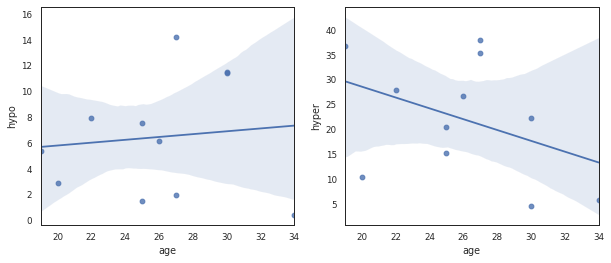

In [34]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
sns.regplot(x='age', y='hypo', data=diab, ax=axs[0])
sns.regplot(x='age', y='hyper', data=diab, ax=axs[1])
plt.show()

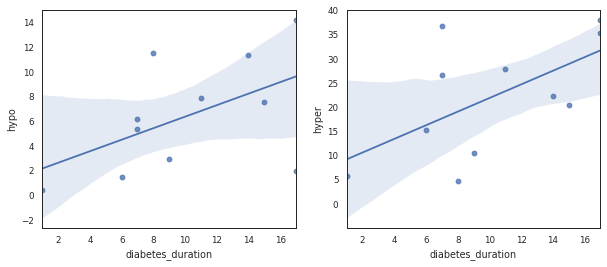

In [37]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
sns.regplot(x='diabetes_duration', y='hypo', data=diab, ax=axs[0])
sns.regplot(x='diabetes_duration', y='hyper', data=diab, ax=axs[1])
plt.show()

In [39]:
import statsmodels.api as sm

diab = sm.add_constant(diab)

model = sm.OLS(diab['hypo'], diab[info.columns])
res = model.fit()
print(res.summary())

model = sm.OLS(diab['hyper'], diab[info.columns])
res = model.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                   hypo   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.858
Method:                 Least Squares   F-statistic:                              7.657
Date:                Tue, 26 Oct 2021   Prob (F-statistic):                       0.275
Time:                        21:19:31   Log-Likelihood:                         -14.273
No. Observations:                  11   AIC:                                      48.55
Df Residuals:                       1   BIC:                                      52.53
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

/local/home/evanweenen/.local/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
/local/home/evanweenen/.local/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


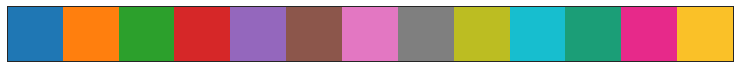

In [196]:
sns.palplot(sns.color_palette('tab10')+[sns.color_palette('Dark2')[0],
                                        sns.color_palette('Dark2')[3],
                                        sns.color_palette('inferno')[-1],
                                        sns.color_palette('inferno')])

In [201]:
sns.color_palette('YlGnBu', n_colors=7)

[(0.9288273740868896, 0.972318339100346, 0.6941637831603229),
 (0.7781776239907728, 0.9128642829680892, 0.7060976547481739),
 (0.4951787773933103, 0.8028604382929643, 0.733748558246828),
 (0.2526874279123414, 0.7114494425221068, 0.7683813917723953),
 (0.11410995770857363, 0.5647058823529412, 0.7510957324106113),
 (0.13361014994232986, 0.3647520184544406, 0.6569780853517878),
 (0.1419761630142253, 0.20144559784698193, 0.5739331026528259)]

In [198]:
sns.color_palette('inferno', n_colors=7)

[(0.129285, 0.047293, 0.290788),
 (0.3415, 0.062325, 0.429425),
 (0.54092, 0.134729, 0.415123),
 (0.735683, 0.215906, 0.330245),
 (0.894305, 0.353399, 0.193584),
 (0.978422, 0.557937, 0.034931),
 (0.974638, 0.797692, 0.206332)]

In [205]:
sns.color_palette('gist_earth_r', n_colors=7)

[(0.8518382084467404, 0.7103140233308513, 0.6171058037787064),
 (0.7389241598191383, 0.6730376114081996, 0.3849495081644698),
 (0.5947984998026056, 0.6844241296518607, 0.3452878910092465),
 (0.35862242511195164, 0.6261367892976589, 0.2930678846538615),
 (0.23071926548397137, 0.5538959866220736, 0.39004938240081705),
 (0.16464755874020998, 0.44614578142248856, 0.49399353175533156),
 (0.08101705271343665, 0.2137804600164292, 0.4712453089602375)]

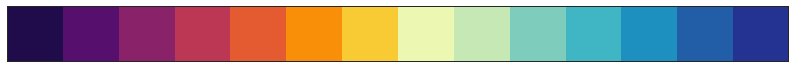

In [202]:
sns.palplot(sns.color_palette('inferno', n_colors=7)+sns.color_palette('YlGnBu', n_colors=7))

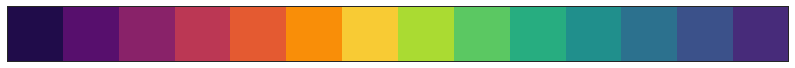

In [212]:
sns.palplot(sns.color_palette('inferno', n_colors=7)+sns.color_palette('viridis_r', n_colors=7))

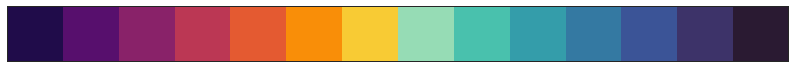

In [208]:
sns.palplot(sns.color_palette('inferno', n_colors=7)+sns.color_palette('mako_r', n_colors=7))

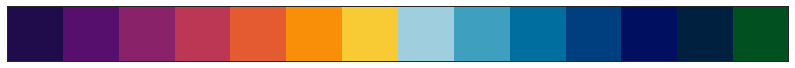

In [210]:
sns.palplot(sns.color_palette('inferno', n_colors=7)+sns.color_palette('ocean_r', n_colors=7))

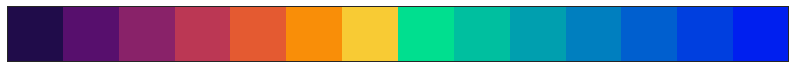

In [215]:
sns.palplot(sns.color_palette('inferno', n_colors=7)+sns.color_palette('winter_r', n_colors=7))

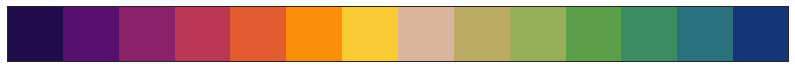

In [206]:
sns.palplot(sns.color_palette('inferno', n_colors=7)+sns.color_palette('gist_earth_r', n_colors=7))

In [189]:
sns.color_palette('tab20b')

[(0.2235294117647059, 0.23137254901960785, 0.4745098039215686),
 (0.3215686274509804, 0.32941176470588235, 0.6392156862745098),
 (0.4196078431372549, 0.43137254901960786, 0.8117647058823529),
 (0.611764705882353, 0.6196078431372549, 0.8705882352941177),
 (0.38823529411764707, 0.4745098039215686, 0.2235294117647059),
 (0.5490196078431373, 0.6352941176470588, 0.3215686274509804),
 (0.7098039215686275, 0.8117647058823529, 0.4196078431372549),
 (0.807843137254902, 0.8588235294117647, 0.611764705882353),
 (0.5490196078431373, 0.42745098039215684, 0.19215686274509805),
 (0.7411764705882353, 0.6196078431372549, 0.2235294117647059),
 (0.9058823529411765, 0.7294117647058823, 0.3215686274509804),
 (0.9058823529411765, 0.796078431372549, 0.5803921568627451),
 (0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
 (0.6784313725490196, 0.28627450980392155, 0.2901960784313726),
 (0.8392156862745098, 0.3803921568627451, 0.4196078431372549),
 (0.9058823529411765, 0.5882352941176471, 0.611764705882353),
 (0.4823529411764706, 0.2549019607843137, 0.45098039215686275),
 (0.6470588235294118, 0.3176470588235294, 0.5803921568627451),
 (0.807843137254902, 0.42745098039215684, 0.7411764705882353),
 (0.8705882352941177, 0.6196078431372549, 0.8392156862745098)]

In [170]:
sns.color_palette('tab10')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [171]:
sns.color_palette('Dark2')

[(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
 (0.4, 0.4, 0.4)]

In [172]:
sns.color_palette('gist_stern')

[(0.5691674045962472, 0.1411764705882353, 0.2823529411764706),
 (0.28627450980392155, 0.28627450980392155, 0.5725490196078431),
 (0.42745098039215684, 0.42745098039215684, 0.8549019607843137),
 (0.5725490196078431, 0.5725490196078431, 0.6912807676261994),
 (0.7137254901960784, 0.7137254901960784, 0.09052982895285744),
 (0.8588235294117648, 0.8588235294117647, 0.4672586015538292)]

In [169]:
sns.color_palette('brg')

[(0.2823529411764706, 0.0, 0.7176470588235294),
 (0.5725490196078431, 0.0, 0.4274509803921569),
 (0.8549019607843137, 0.0, 0.14509803921568631),
 (0.8549019607843137, 0.1450980392156863, 0.0),
 (0.5725490196078431, 0.42745098039215684, 0.0),
 (0.2823529411764706, 0.7176470588235294, 0.0)]

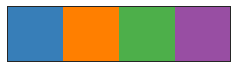

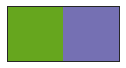

In [234]:
sns.palplot(color_sec.values()) ; plt.show()

sns.palplot([sns.color_palette('Dark2')[4], sns.color_palette('Dark2')[2]]) ; plt.show()

In [2]:
import seaborn as sns
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [3]:
sns.color_palette('Set1')

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

In [10]:
from plot import palette_ath

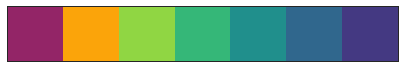

In [48]:
sns.palplot(sns.color_palette('inferno', n_colors=4)[1::2]+sns.color_palette('viridis_r', n_colors=5))

In [141]:
sns.color_palette('Set2')

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [142]:
sns.color_palette('Set3')

[(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
 (1.0, 1.0, 0.7019607843137254),
 (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
 (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
 (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
 (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
 (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
 (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
 (0.7372549019607844, 0.5019607843137255, 0.7411764705882353),
 (0.8, 0.9215686274509803, 0.7725490196078432),
 (1.0, 0.9294117647058824, 0.43529411764705883)]

In [144]:
sns.color_palette('Set1')

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

In [117]:
sns.color_palette('tab10')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [145]:
sns.color_palette('tab20', n_colors=14)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058)]

In [147]:
sns.color_palette('tab20b')

[(0.2235294117647059, 0.23137254901960785, 0.4745098039215686),
 (0.3215686274509804, 0.32941176470588235, 0.6392156862745098),
 (0.4196078431372549, 0.43137254901960786, 0.8117647058823529),
 (0.611764705882353, 0.6196078431372549, 0.8705882352941177),
 (0.38823529411764707, 0.4745098039215686, 0.2235294117647059),
 (0.5490196078431373, 0.6352941176470588, 0.3215686274509804),
 (0.7098039215686275, 0.8117647058823529, 0.4196078431372549),
 (0.807843137254902, 0.8588235294117647, 0.611764705882353),
 (0.5490196078431373, 0.42745098039215684, 0.19215686274509805),
 (0.7411764705882353, 0.6196078431372549, 0.2235294117647059),
 (0.9058823529411765, 0.7294117647058823, 0.3215686274509804),
 (0.9058823529411765, 0.796078431372549, 0.5803921568627451),
 (0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
 (0.6784313725490196, 0.28627450980392155, 0.2901960784313726),
 (0.8392156862745098, 0.3803921568627451, 0.4196078431372549),
 (0.9058823529411765, 0.5882352941176471, 0.611764705882353),
 (0.4823529411764706, 0.2549019607843137, 0.45098039215686275),
 (0.6470588235294118, 0.3176470588235294, 0.5803921568627451),
 (0.807843137254902, 0.42745098039215684, 0.7411764705882353),
 (0.8705882352941177, 0.6196078431372549, 0.8392156862745098)]

In [148]:
sns.color_palette('tab20c')

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961)]

In [149]:
sns.color_palette('Paired')

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392),
 (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765)]

In [159]:
sns.color_palette('Dark2')

[(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
 (0.4, 0.4, 0.4)]

In [203]:
sns.color_palette('gist_stern', n_colors=14)

[(0.9403811230585424, 0.06666666666666667, 0.13333333333333333),
 (0.6082425328554361, 0.13333333333333333, 0.26666666666666666),
 (0.27610394265232974, 0.2, 0.4),
 (0.26666666666666666, 0.26666666666666666, 0.5333333333333333),
 (0.3333333333333333, 0.3333333333333333, 0.6666666666666666),
 (0.4, 0.4, 0.8),
 (0.4666666666666667, 0.4666666666666667, 0.9333333333333333),
 (0.5333333333333333, 0.5333333333333333, 0.8581560283687943),
 (0.6, 0.6, 0.5744680851063828),
 (0.6666666666666667, 0.6666666666666666, 0.2907801418439714),
 (0.7333333333333334, 0.7333333333333333, 0.007092198581559961),
 (0.7999999999999999, 0.8, 0.24528301886792472),
 (0.8666666666666667, 0.8666666666666667, 0.4968553459119498),
 (0.9333333333333333, 0.9333333333333333, 0.7484276729559749)]

In [168]:
sns.color_palette('brg')

[(0.2823529411764706, 0.0, 0.7176470588235294),
 (0.5725490196078431, 0.0, 0.4274509803921569),
 (0.8549019607843137, 0.0, 0.14509803921568631),
 (0.8549019607843137, 0.1450980392156863, 0.0),
 (0.5725490196078431, 0.42745098039215684, 0.0),
 (0.2823529411764706, 0.7176470588235294, 0.0)]

In [162]:
sns.color_palette('CMRmap')

[(0.16941176470588235, 0.15, 0.5323529411764706),
 (0.3870588235294118, 0.16450980392156864, 0.6774509803921569),
 (0.7678431372549019, 0.22098039215686274, 0.3531372549019608),
 (0.9419607843137255, 0.3950980392156863, 0.06294117647058822),
 (0.9, 0.6774509803921569, 0.07098039215686275),
 (0.9, 0.8805882352941177, 0.44823529411764707)]

In [163]:
sns.color_palette('Spectral')

[(0.8853517877739331, 0.3190311418685121, 0.29042675893886966),
 (0.9873125720876587, 0.6473663975394078, 0.3642445213379469),
 (0.9971549404075356, 0.9118031526336025, 0.6010765090349866),
 (0.9288735101883892, 0.9715494040753557, 0.6380622837370243),
 (0.6334486735870821, 0.8521337946943485, 0.6436755094194541),
 (0.2800461361014994, 0.6269896193771626, 0.7024221453287197)]

In [164]:
sns.color_palette('RdYlBu')

[(0.8899653979238754, 0.2867358708189158, 0.19815455594002307),
 (0.9873125720876587, 0.6473663975394078, 0.3642445213379469),
 (0.9971549404075356, 0.9118031526336025, 0.6153018069973087),
 (0.9118031526336026, 0.9658592848904267, 0.9111880046136099),
 (0.6409842368319879, 0.8272971933871589, 0.90080738177624),
 (0.346482122260669, 0.5492502883506344, 0.7527104959630911)]

In [165]:
sns.color_palette('plasma')

[(0.32515, 0.006915, 0.639512),
 (0.546157, 0.038954, 0.64701),
 (0.723444, 0.196158, 0.538981),
 (0.85975, 0.360588, 0.406917),
 (0.95547, 0.533093, 0.28549),
 (0.994495, 0.74088, 0.166335)]

In [166]:
sns.color_palette('inferno')

[(0.15585, 0.044559, 0.325338),
 (0.397674, 0.083257, 0.433183),
 (0.621685, 0.164184, 0.388781),
 (0.832299, 0.283913, 0.257383),
 (0.961293, 0.488716, 0.084289),
 (0.981173, 0.759135, 0.156863)]

In [167]:
sns.color_palette('rocket')

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]